In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import torch
from tqdm import tqdm
from random import random
import matplotlib.colors as mcolors
import matplotlib.cm as cm

#sns darkgrid
sns.set_style("darkgrid")

%matplotlib inline
%cd /net/pulsar/home/koes/jok120/openfold

# RESULTS_BASE_DIRS = ["/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A", "/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B"]
RESULTS_BASE_DIRS = [
    "/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A",
    "/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C",
                    #   "/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B",
                      ]
# RESULTS_BASE_DIRS += ["/net/pulsar/home/koes/jok120/openfold/out/evaluation/230719", "/net/pulsar/home/koes/jok120/openfold/out/evaluation/230731"]

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 110
# Make font size about 50% larger
mpl.rcParams['font.size'] = 14

/net/pulsar/home/koes/jok120/openfold


# DataFrame Setup

In [14]:
def create_dataframe_dict(eval_dirs):
    df_dict = {}
    for (model_name, basedir) in eval_dirs:
        # for split in ['val']:
        for split in ['val', 'test']:
            # for identity in ['pred', 'true', 'pred_relaxed', 'true_relaxed']:
            for identity in ['pred', 'pred_relaxed']:
                try:
                    molpro_csv = os.path.join(basedir, model_name, "pdbs", split, identity, "molprobity.out")
                    print(molpro_csv)
                    molpro_df = pd.read_csv(molpro_csv, skiprows=1, sep=":")
                    if 'relaxed' in identity:
                        molpro_df["protein_name"] = molpro_df["#pdbFileName"].str[:-12]
                    else:
                        molpro_df["protein_name"] = molpro_df["#pdbFileName"].str[:-4]

                    # Update some molpro cols, rotaOutlier:rotaFavored:numRota:ramaOutlier:ramaAllowed:ramaFavored:numRama
                    #pct_badbonds, pct_badangles
                    molpro_df["percentRamaFavored"] = molpro_df["ramaFavored"] / molpro_df["numRama"] * 100
                    molpro_df["percentRotaFavored"] = molpro_df["rotaFavored"] / molpro_df["numRota"] * 100
                    molpro_df["percentRamaAllowed"] = molpro_df["ramaAllowed"] / molpro_df["numRama"] * 100
                    molpro_df["percentRamaOutlier"] = molpro_df["ramaOutlier"] / molpro_df["numRama"] * 100
                    molpro_df["percentRotaOutlier"] = molpro_df["rotaOutlier"] / molpro_df["numRota"] * 100
                    if 'relaxed' not in identity:
                        print((model_name, split, identity))
                        df_dict[(model_name, split, identity)] = molpro_df.copy()
                        continue
                    relaxation_times_df = pd.read_csv(os.path.join(basedir, model_name, "pdbs", split, identity, "relaxation_times.csv"))
                    molpro_df = molpro_df.merge(relaxation_times_df, on="protein_name")
                    print((model_name, split, identity))
                    df_dict[(model_name, split, identity)] = molpro_df
                except FileNotFoundError:
                    print("did not find", model_name, basedir, split, identity)
    return df_dict

In [16]:
eval_dirs = [(subdir, basedir) for basedir in RESULTS_BASE_DIRS for subdir in os.listdir(basedir) if ("eval" in subdir or "finetuning" in subdir )]
for ed in eval_dirs: print(ed)

df_dict = create_dataframe_dict(eval_dirs)

# # REMOVE THIS!!!!
# print("!!!!!!!!!!!!!!!!! REMOVE THIS!!!!!!!!!!!!!")
# df_dict = {k: v for k, v in df_dict.items() if "del" not in k[0]}
print(list(df_dict.keys()))


('eval_resnet_baseline', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_resnet_baseline_not_AF2_toastyRN1', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_young_sweep_159', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_toastyC0_repeat_noconvB', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_resnet_baseline_AF2_untrained', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_atxl', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('del_eval_resnet_baseline_not_AF2_toastyRN1_finetuned', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('del_first_few_eval_toastyC0_repeat_noconvB_finetuned', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_toastyC0_repeat_noconvB_finetuned', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_resnet_baseline_not_AF2_toastyRN1_finetuned', '/net/pulsar/home/koes/jok120/openfold/out/e

In [ ]:
!head -n3 /net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-RESUME/test_results.csv

In [ ]:
!head -n3 /net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/eval_angletransformer-scnmin-00-RN-OMM-toasty-long-a100/test_results.csv

In [17]:
# Merge MolProbity and Accuracy CSVs

# AF OMM
name = "eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-RESUME"
acc_df_baseline0 = pd.read_csv(f"/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/{name}/test_results.csv")
molpro_df_baseline0 = df_dict[(name, 'test', 'pred')]
molpro_df_baseline0["protein_name"] = molpro_df_baseline0["protein_name"].str.split("_", n=2, expand=True)[2]
df_dict[(name, 'test', 'pred')] = molpro_df_baseline0.merge(acc_df_baseline0, on="protein_name")

# AF OMM RESUME2
name = "eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-wholemodel-RESUME2"
acc_df_baseline7 = pd.read_csv(f"/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/{name}/test_results.csv")
molpro_df_baseline7 = df_dict[(name, 'test', 'pred')]
molpro_df_baseline7["protein_name"] = molpro_df_baseline7["protein_name"].str.split("_", n=2, expand=True)[2]
df_dict[(name, 'test', 'pred')] = molpro_df_baseline7.merge(acc_df_baseline7, on="protein_name")

# AT noMM RESUME2
name = "eval_angletransformer-scnmin-00-AT-noOMM-toasty-long-a100-wholemodel-RESUME2"
acc_df_baseline8 = pd.read_csv(f"/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/{name}/test_results.csv")
molpro_df_baseline8 = df_dict[(name, 'test', 'pred')]
molpro_df_baseline8["protein_name"] = molpro_df_baseline8["protein_name"].str.split("_", n=2, expand=True)[2]
df_dict[(name, 'test', 'pred')] = molpro_df_baseline8.merge(acc_df_baseline8, on="protein_name")

# RN OMM RESUME2
name = "eval_angletransformer-scnmin-00-RN-OMM-toasty-long-a100-wholemodel-RESUME2"
acc_df_baseline9 = pd.read_csv(f"/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/{name}/test_results.csv")
molpro_df_baseline9 = df_dict[(name, 'test', 'pred')]
molpro_df_baseline9["protein_name"] = molpro_df_baseline9["protein_name"].str.split("_", n=2, expand=True)[2]
df_dict[(name, 'test', 'pred')] = molpro_df_baseline9.merge(acc_df_baseline9, on="protein_name")

# RN noOMM RESUME2
name = "eval_angletransformer-scnmin-00-RN-noOMM-toasty-long-a100-wholemodel-RESUME2"
acc_df_baseline10 = pd.read_csv(f"/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/{name}/test_results.csv")
molpro_df_baseline10 = df_dict[(name, 'test', 'pred')]
molpro_df_baseline10["protein_name"] = molpro_df_baseline10["protein_name"].str.split("_", n=2, expand=True)[2]
df_dict[(name, 'test', 'pred')] = molpro_df_baseline10.merge(acc_df_baseline10, on="protein_name")



# AF noOMM
acc_df_baseline1 = pd.read_csv("/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/eval_angletransformer-scnmin-00-AT-noOMM-toasty/test_results.csv")
molpro_df_baseline1 = df_dict[('eval_angletransformer-scnmin-00-AT-noOMM-toasty', 'test', 'pred')]
molpro_df_baseline1["protein_name"] = molpro_df_baseline1["protein_name"].str.split("_", n=2, expand=True)[2]
df_dict[('eval_angletransformer-scnmin-00-AT-noOMM-toasty', 'test', 'pred')] = molpro_df_baseline1.merge(acc_df_baseline1, on="protein_name")


# RN OMM
acc_df_baseline2 = pd.read_csv("/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/eval_angletransformer-scnmin-00-RN-OMM-toasty-long-a100/test_results.csv")
molpro_df_baseline2 = df_dict[('eval_angletransformer-scnmin-00-RN-OMM-toasty-long-a100', 'test', 'pred')]
molpro_df_baseline2["protein_name"] = molpro_df_baseline2["protein_name"].str.split("_", n=2, expand=True)[2]
df_dict[('eval_angletransformer-scnmin-00-RN-OMM-toasty-long-a100', 'test', 'pred')] = molpro_df_baseline2.merge(acc_df_baseline2, on="protein_name")


#RN no-OMM
acc_df_baseline3 = pd.read_csv("/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/eval_angletransformer-scnmin-00-RN-noOMM-toasty-long-a100/test_results.csv")
molpro_df_baseline3 = df_dict[('eval_angletransformer-scnmin-00-RN-noOMM-toasty-long-a100', 'test', 'pred')]
molpro_df_baseline3["protein_name"] = molpro_df_baseline3["protein_name"].str.split("_", n=2, expand=True)[2]
df_dict[('eval_angletransformer-scnmin-00-RN-noOMM-toasty-long-a100', 'test', 'pred')] = molpro_df_baseline3.merge(acc_df_baseline3, on="protein_name")

#AT-OMM-10x
acc_df_baseline4 = pd.read_csv("/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-chw0.5-omm0.1/test_results.csv")
molpro_df_baseline4 = df_dict[('eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-chw0.5-omm0.1', 'test', 'pred')]
molpro_df_baseline4["protein_name"] = molpro_df_baseline4["protein_name"].str.split("_", n=2, expand=True)[2]
df_dict[('eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-chw0.5-omm0.1', 'test', 'pred')] = molpro_df_baseline4.merge(acc_df_baseline4, on="protein_name")


#AT-FrankenModel-noOMM
acc_df_baseline5 = pd.read_csv("/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/eval_AT-frankenstein-noOMM-toasty/test_results.csv")
molpro_df_baseline5 = df_dict[('eval_AT-frankenstein-noOMM-toasty', 'test', 'pred')]
molpro_df_baseline5["protein_name"] = molpro_df_baseline5["protein_name"].str.split("_", n=2, expand=True)[2]
df_dict[('eval_AT-frankenstein-noOMM-toasty', 'test', 'pred')] = molpro_df_baseline4.merge(acc_df_baseline5, on="protein_name")


#AT-FrankenModel-OMM
acc_df_baseline6 = pd.read_csv("/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3C/eval_AT-frankenstein-OMM-toasty/test_results.csv")
molpro_df_baseline6 = df_dict[('eval_AT-frankenstein-OMM-toasty', 'test', 'pred')]
molpro_df_baseline6["protein_name"] = molpro_df_baseline6["protein_name"].str.split("_", n=2, expand=True)[2]
df_dict[('eval_AT-frankenstein-OMM-toasty', 'test', 'pred')] = molpro_df_baseline6.merge(acc_df_baseline6, on="protein_name")


# Defs

In [18]:
# Compare baseline times to my model times
# plt.ioff()
def make_accuracy_plot(dfx,
                       dfy,
                       dfx_name,
                       dfy_name,
                       dataset_split,
                       metric="gdcall_aa",
                       hue="",
                       hue_is_y=True,
                       hue_is_yraw=False,
                       use_log=False,
                       use_cube_root=False,
                       alpha=1,
                       size=3,
                       ax=None,
                       index=0,
                       save_prefix="",
                       fig=None,
                    #    label_energy_df=get_label_energy_df(),
                       scale_hue=1,
                       add_split=False,
                       nbins=7,
                       custom_title=None,
                       color=None,
                       ):
    """Make a scatter plot with seaborn comparing methods dfx and dfy on metric.
    Each row of the dataframes correspond to a different protein. For each protein,
    plot a point on the scatter plot with x-value equal to the metric value for dfx
    and y-value equal to the metric value for dfy.
    First join the dataframes on the protein column using suffixes to rename duplicate cols,
    then plot the metric values for each method.
    """
    

    df = dfx.merge(dfy, on="protein_name", suffixes=(f"_{dfx_name}", f"_{dfy_name}"))


    xmetric = f"{metric}_{dfx_name}"
    ymetric = f"{metric}_{dfy_name}"

    # determine the min and max values over the x and y axis to set the limits of the plot uniformly
    # However, add a buffer to the min and max values so that the points are not on the edge of the plot
    min_val = min(df[xmetric].min(), df[ymetric].min())
    max_val = max(df[xmetric].max(), df[ymetric].max())

    if metric == "lddt_aa":
        min_val = 0
        max_val = 1

    # Add a buffer to the min and max values
    buffer = 0.05 * (max_val - min_val)
    min_val -= buffer
    max_val += buffer
    
    if ax is None and hue is not "":
        fig, ax = plt.subplots(figsize=(size*1.15, size));
    elif ax is None:
        fig, ax = plt.subplots(figsize=(size*1, size));

    # Set the appropriate x and y axis limits using the fig and ax variables
    # Use the min and max values calculated above

    # make sure no limit is nan or inf
    if not np.isnan(min_val) and not np.isinf(min_val):
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
    
    # plot a dotted line y=x on the same figure without displaying it
    ax.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="black", alpha=0.5);


    # if hue is not empty, use it to color the points
    if hue:
        # Use coolwarm colormap, with negative values being red and positive values being blue
        if hue_is_yraw:
            name = hue
        elif hue_is_y:
            name = f"{hue}_{dfy_name}"
        else:
            name = f"{hue}_{dfx_name}"
        try:
            vals = df[name] / scale_hue
        except KeyError:
            print(f"{name} not found in df")
            print(df.columns)
            return
        if 'energy' in hue or 'openmm' in hue:
            vmin, vmax = vals.min(), vals.max()
            vcenter = 0
            if vmin > 0:
                vcenter = vmin + 1e-6

        else:
            vmin = 0
            vmax = 1
            vcenter = 0.5
        assert (vmin < vcenter < vmax), f"{name}: Must have vmin < vcenter < vmax, but got vmin: {vmin}, vcenter: {vcenter}, vmax: {vmax}"
        print(f"vmin: {vmin}, vmax: {vmax}, vcenter: {vcenter}")

        normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap='coolwarm' if vcenter == 0 or 'pct' not in hue or 'percent' not in hue else 'Blues')
        scalarmappaple.set_array(vals)
        plt.colorbar(scalarmappaple, label=name)


    if hue and hue_is_yraw:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, hue=hue, ax=ax, alpha=alpha, palette='coolwarm' if vcenter == 0 else 'Blues', norm=normalize);
    elif hue and hue_is_y:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, hue=f"{hue}_{dfy_name}", ax=ax, alpha=alpha, palette='coolwarm' if vcenter == 0 else 'Blues');
    elif hue and not hue_is_y:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, hue=f"{hue}_{dfx_name}", ax=ax, alpha=alpha);
    else:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, ax=ax, alpha=alpha, color=color, linewidth=0);
    
    
    # Set number of x and y ticks to be the same
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins))
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins))


    # Get the mean values for each method
    dfx_mean = df[xmetric].mean()
    dfy_mean = df[ymetric].mean()

    # Set the position of the box
    ax.text(
        0.05,
        0.95,
        f"y mean: {dfy_mean:.3f}\nx mean: {dfx_mean:.3f}\ny-x: {dfy_mean - dfx_mean:.3f}\ny std: {df[ymetric].std():.2f}\nx std: {df[xmetric].std():.2f}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=dict(boxstyle="square", facecolor="white", alpha=0.5),
    )

    dfx_name = dfx_name.replace(" + relax", "")
    dfy_name = dfy_name.replace(" + relax", "")

    plt.xlabel(f"{dfx_name}");
    plt.ylabel(f"{dfy_name}");
    if add_split:
        plt.title(f"{metric} : {dataset_split}");
    else:
        if metric == "clashscore":
            metric_title = "Clash Score"
        elif metric == "MolProbityScore":
            metric_title = "MolProbity Score"
        elif metric == "lddt_aa":
            metric_title = r'lDDT$_{AA}$'
        elif metric == "openmm":
            metric_title = "OpenMM Loss"
        elif metric == "angle_mae":
            metric_title = "Angle MAE (degrees)"
        else:
            metric_title = metric
        if custom_title is not None:
            plt.title(custom_title);
        else:
            plt.title(metric_title);

    if hue is not "":
        ax.get_legend().remove()

    # Ensure a white background
    if fig:
        fig.patch.set_facecolor('white')

    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")
    

    

    # Return the plot
    return ax




<>:56: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:162: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:56: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:162: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_1874960/66310532.py:56: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if ax is None and hue is not "":
/tmp/ipykernel_1874960/66310532.py:162: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if hue is not "":


In [19]:
def make_barplot(dfx, dfy, dfx_name, dfy_name, metric, dataset_split, hue=None, hue_is_y=False,
                  alpha=0.9, size=4, save_prefix=None, index=0, fliers=False, dotsize=3):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Concatenate the two dataframes
    df = pd.concat([dfx, dfy])

    # Add a column to the dataframe to indicate the source of each row
    df["source"] = [dfx_name] * len(dfx) + [dfy_name] * len(dfy)

    # Plot the barplot
    sns.boxplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], ax=ax, showfliers=fliers);
    sns.swarmplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], alpha=alpha, ax=ax, color='black', size=dotsize);

    # Set the y axis label to be the metric
    plt.ylabel(metric);

    # Set the title of the plot to be the metric and the dataset split
    plt.title(f"{metric} : {dataset_split}");

    # Rotate the entire plot 
    plt.xticks(rotation=20);


    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")

    # Return the plot
    return ax


def make_3barplot(dfx, dfy, dfz, dfx_name, dfy_name, dfz_name, metric, dataset_split, hue=None, hue_is_y=False,
                  alpha=0.9, size=4, save_prefix=None, index=0, fliers=False, dotsize=3):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Concatenate the two dataframes
    df = pd.concat([dfx, dfy, dfz])

    # Add a column to the dataframe to indicate the source of each row
    df["source"] = [dfx_name] * len(dfx) + [dfy_name] * len(dfy) + [dfz_name] * len(dfz)

    # Plot the barplot
    sns.boxplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], ax=ax, showfliers=fliers);
    sns.swarmplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], alpha=alpha, ax=ax, color='black', size=dotsize);

    # Set the y axis label to be the metric
    plt.ylabel(metric);

    # Set the title of the plot to be the metric and the dataset split
    plt.title(f"{metric} : {dataset_split}");

    # Rotate the entire plot 
    plt.xticks(rotation=20);


    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")

    # Return the plot
    return ax

def make_nbarplot(dfs, df_names, metric, dataset_split, hue=None, hue_is_y=False,
                  alpha=0.9, size=4, save_prefix=None, index=0, fliers=False, dotsize=3, title_suffix='', add_split=False, swarm=True, violin=False):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Concatenate the two dataframes
    df = pd.concat(dfs)

    # Add a column to the dataframe to indicate the source of each row
    new_source = []
    for i, d in enumerate(dfs):
        new_source += [df_names[i]] * len(d)
    df["source"] = new_source
    # If "+ relax" in source, replace with ''
    df["source"] = df["source"].str.replace(" + relax", "", regex=False)

    # Plot the barplot
    if not violin:
        sns.boxplot(data=df, y="source", x=metric, hue=hue, hue_order=["baseline", "comparison"], ax=ax, showfliers=fliers);
    else:
        sns.violinplot(data=df, y="source", x=metric, hue=hue, hue_order=["baseline", "comparison"], ax=ax, showfliers=fliers, split=True);#, inner="quartile");
    if swarm:
        sns.swarmplot(data=df, y="source", x=metric, hue=hue, hue_order=["baseline", "comparison"], alpha=alpha, ax=ax, color='black', size=dotsize);

    # Set the y axis label to be the metric
    # plt.ylabel("Model");
    if metric == "clashscore":
        metric_title = "Clash Score" 
    elif metric == "MolProbityScore":
        metric_title = "MolProbity Score"
    elif metric == "pct_rank":
        metric_title = "Clash Score Percentile"
    elif metric in ["openmm", "openmm_unscaled"]:
        metric_title = "OpenMM-Loss"
    else:
        metric_title = metric

    plt.xlabel(metric_title);

    # Remove y label
    ax.set_ylabel('')

    # Set the title of the plot to be the metric and the dataset split
    if add_split:
        plt.title(f"{metric} : {dataset_split} " + title_suffix);
    else:
        pass
        # plt.title(metric_title + title_suffix);

    # Rotate the entire plot 
    # plt.xticks(rotation=20);

    # Make background outside plot opaque instead of transparent. Keep color inside plot the same

    # tight layout
    # plt.tight_layout()


    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")

    # Return the plot
    return ax


def make_nbarplot_vert(dfs, df_names, metric, dataset_split, hue=None, hue_is_y=False,
                  alpha=0.9, size=4, save_prefix=None, index=0, fliers=False, dotsize=3, title_suffix='', add_split=False, swarm=True):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Concatenate the two dataframes
    df = pd.concat(dfs)

    # Add a column to the dataframe to indicate the source of each row
    new_source = []
    for i, d in enumerate(dfs):
        new_source += [df_names[i]] * len(d)
    df["source"] = new_source

    # Plot the barplot
    sns.boxplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], ax=ax, showfliers=fliers);

    if swarm:
        sns.swarmplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], alpha=alpha, ax=ax, color='black', size=dotsize);

    # Set the y axis label to be the metric
    plt.ylabel(metric);

    # Set the title of the plot to be the metric and the dataset split
    if add_split:
        plt.title(f"{metric} : {dataset_split} " + title_suffix);
    else:
        plt.title(f"{metric} " + title_suffix);

    # Rotate the entire plot 
    plt.xticks(rotation=20);


    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")

    # Return the plot
    return ax

def make_chi_angle_grouped_barplot(dataframes, model_names, save_prefix=""):
    """
    Plot grouped box plot with a swarm plot on top.
    
    Parameters:
    - dataframes: List of DataFrames containing the prediction data.
    - model_names: List of model names corresponding to the DataFrames.
    
    Each DataFrame should have columns 'x1_mae', 'x2_mae', 'x3_mae', and 'x4_mae'.
    """
    # Combine dataframes into a single dataframe with an additional 'Model' column
    combined_data = pd.concat(
        [df.assign(Model=model) for df, model in zip(dataframes, model_names)],
        axis=0
    )

    # Melt the dataframe to long format
    melted_data = combined_data.melt(id_vars=['Model'], value_vars=['angle_mae', 'x1_mae', 'x2_mae', 'x3_mae', 'x4_mae'], 
                                     var_name="$X_i$", value_name='mae')

    # Create the plots
    plt.figure(figsize=(12, 8))
    
    # Box plot
    # make sure to set the x label names to "$X_1$", "$X_2$", "$X_3$", "$X_4$" and ticks
    box_plot = sns.boxplot(x='$X_i$', y='mae', hue='Model', data=melted_data, showfliers=False)  

    # Swarm plot with no legend entries
    sns.swarmplot(x="$X_i$", y='mae', hue='Model', data=melted_data, dodge=True, size=3, color='black')

    # Set the legend for the box plot only
    handles, labels = box_plot.get_legend_handles_labels()
    print(len(model_names))
    l = plt.legend(handles=handles[0:len(model_names)], labels=labels[0:len(model_names)], loc='upper right')

    
    # plt.legend(loc='upper right')
    plt.ylabel('Mean Absolute Error (degrees)')
    plt.xlabel("Chi Angle")
    plt.xticks([0, 1, 2, 3, 4], ["All", "$X_1$", "$X_2$", "$X_3$", "$X_4$"])    
    plt.title('Sidechain $X_i$ Mean Absolute Error (degrees)')
    

        # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")


def make_ngroupedbarplot(dfs, df_names, metric, dataset_split, hue=None, hue_is_y=False,
                  alpha=0.9, size=4, save_prefix=None, index=0, fliers=False, dotsize=3, do_swarm=False, title_suffix = ""):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Concatenate the two dataframes
    df = pd.concat(dfs)

    # Add a column to the dataframe to indicate the source of each row
    new_source = []
    for i, d in enumerate(dfs):
        new_source += [df_names[i]] * len(d)
    df["source"] = new_source
    df['is_relaxed'] = df['source'].apply(lambda x: 'relax' in x)
    df['model'] = df['source'].apply(lambda x: x.replace(' + relax', '').strip())    

    # Plot the barplot
    sns.boxplot(data=df, x=metric, y="model", hue='is_relaxed', ax=ax, showfliers=fliers);
    if do_swarm:
        sns.swarmplot(data=df, x=metric, y="model", hue=None, alpha=alpha, ax=ax, color='black', size=dotsize);

    # Set the y axis label to be the metric
    plt.ylabel(metric);

    # Set the title of the plot to be the metric and the dataset split
    plt.title(f"{metric} : {dataset_split}" + title_suffix);

    # Rotate the entire plot 
    # plt.xticks(rotation=90);


    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")

    # Return the plot
    return ax

def make_ngroupedbarplot_vert(dfs, df_names, metric, dataset_split, hue=None, hue_is_y=False,
                  alpha=0.9, size=4, save_prefix=None, index=0, fliers=False, dotsize=3, do_swarm=False, title_suffix = ""):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Concatenate the two dataframes
    df = pd.concat(dfs)

    # Add a column to the dataframe to indicate the source of each row
    new_source = []
    for i, d in enumerate(dfs):
        new_source += [df_names[i]] * len(d)
    df["source"] = new_source
    df['Relaxed'] = df['source'].apply(lambda x: 'relax' in x)
    df['model'] = df['source'].apply(lambda x: x.replace(' + relax', '').strip())    

    # Plot the barplot
    sns.boxplot(data=df, y=metric, x="model", hue='Relaxed', ax=ax, showfliers=fliers,hue_order=[False,True]);
    if do_swarm:
        sns.swarmplot(data=df, y=metric, x="model", hue='Relaxed', alpha=alpha, ax=ax, color='black', size=dotsize);

    # Set the y axis label to be the metric
    plt.ylabel(metric);

    # Set the title of the plot to be the metric and the dataset split
    plt.title(f"{metric} : {dataset_split}" + title_suffix);

    # Rotate the entire plot 
    # plt.xticks(rotation=90);


    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")

    # Return the plot
    return ax

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_residue_type_grouped_plot(dataframes, model_names, save_prefix=""):
    """
    Plot grouped box plot with a swarm plot on top comparing hydrophobic and hydrophilic residues.
    
    Parameters:
    - dataframes: List of DataFrames containing the prediction data.
    - model_names: List of model names corresponding to the DataFrames.
    
    Each DataFrame should have columns corresponding to residue MAEs like 'VAL_mae' or 'CYS_mae'.
    """
    
    # Define hydrophobic and hydrophilic residues (3-letter codes)
    hydrophobic_residues = ['ALA', 'ILE', 'LEU', 'VAL', 'PRO', 'PHE', 'MET', 'TRP', 'CYS']
    hydrophilic_residues = ['SER', 'THR', 'ASN', 'GLN', 'TYR', 'ARG', 'HIS', 'LYS', 'ASP', 'GLU']
    
    def group_residues(df):
        # Combine hydrophobic and hydrophilic residues into separate columns
        df['Hydrophobic Residues'] = df[[f"{residue}_mae" for residue in hydrophobic_residues if f"{residue}_mae" in df.columns]].mean(axis=1)
        df['Hydrophilic Residues'] = df[[f"{residue}_mae" for residue in hydrophilic_residues if f"{residue}_mae" in df.columns]].mean(axis=1)
        return df[['Hydrophobic Residues', 'Hydrophilic Residues']]
    
    # Combine data
    combined_data = pd.concat(
        [group_residues(df.copy()).assign(Model=model) for df, model in zip(dataframes, model_names)],
        axis=0
    )
    
    melted_data = combined_data.melt(id_vars=['Model'], value_vars=['Hydrophobic Residues', 'Hydrophilic Residues'], 
                                     var_name="ResidueType", value_name='mae')
    
    # Create the plots
    plt.figure(figsize=(12, 8))
    
    # Box plot
    box_plot = sns.boxplot(x='ResidueType', y='mae', hue='Model', data=melted_data, showfliers=False)  

    # Swarm plot
    sns.swarmplot(x='ResidueType', y='mae', hue='Model', data=melted_data, dodge=True, size=3, color='black')
    
    # Set the legend for the box plot only
    handles, labels = box_plot.get_legend_handles_labels()
    box_plot.legend(handles=handles[0:len(model_names)], labels=labels[0:len(model_names)])

    plt.ylabel('Mean Absolute Error (degrees)')
    plt.xlabel("Residue Type")
    plt.title('Mean Absolute Prediction Error for Hydrophobic vs. Hydrophilic Residues')
    
    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_amino_acid_grouped_plot(dataframes, model_names, save_prefix="", size=3):
    """
    Plot grouped box plot with a swarm plot on top comparing all amino acid residues.
    
    Parameters:
    - dataframes: List of DataFrames containing the prediction data.
    - model_names: List of model names corresponding to the DataFrames.
    
    Each DataFrame should have columns corresponding to residue MAEs like 'VAL_mae' or 'CYS_mae'.
    """
    
    # List of all amino acid residues (3-letter codes)
    all_residues = ['angle', 'ILE', 'LEU', 'VAL', 'PRO', 'PHE', 'MET', 'TRP',
                    'SER', 'THR', 'ASN', 'GLN', 'TYR', 'CYS', 'ARG', 'HIS', 
                    'LYS', 'ASP', 'GLU']
    
    # Extract relevant columns and assign model name
    dfs = []
    for df, model in zip(dataframes, model_names):
        relevant_cols = [f"{residue}_mae" for residue in all_residues if f"{residue}_mae" in df.columns]
        temp_df = df[relevant_cols].copy()
        temp_df['Model'] = model
        dfs.append(temp_df)

    # Combine data
    combined_data = pd.concat(dfs, axis=0).melt(id_vars=['Model'], value_vars=[f"{residue}_mae" for residue in all_residues],
                                                var_name="AminoAcid", value_name='mae')
    
    # Strip '_mae' from the AminoAcid column for cleaner visualization
    combined_data["AminoAcid"] = combined_data["AminoAcid"].str.replace('_mae', '')
    
    # Create the plots
    plt.figure(figsize=(20, 8))
    
    # Box plot
    box_plot = sns.boxplot(x='AminoAcid', y='mae', hue='Model', data=combined_data, showfliers=False)  

    # Swarm plot
    sns.swarmplot(x='AminoAcid', y='mae', hue='Model', data=combined_data, dodge=True, size=size, color='black')
    
    # Set the legend for the box plot only
    handles, labels = box_plot.get_legend_handles_labels()
    box_plot.legend(handles=handles[0:len(model_names)], labels=labels[0:len(model_names)])

    plt.ylabel('Mean Absolute Error (degrees)')
    plt.xlabel("Amino Acid Residue")
    plt.title('Mean Absolute Prediction Error by Amino Acid Residue')
    
    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")

    plt.show()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_prediction_metrics_grouped_plot(dataframes, model_names, save_prefix=""):
    """
    Plot grouped box plot with a swarm plot on top comparing metrics: angle_mae, x1_mae, and normalized lddt_aa.
    
    Parameters:
    - dataframes: List of DataFrames containing the prediction data.
    - model_names: List of model names corresponding to the DataFrames.
    
    Each DataFrame should have columns 'angle_mae', 'x1_mae', and 'lddt_aa'.
    """
    
    # Extract and compute the relevant columns and assign model name
    dfs = []
    for df, model in zip(dataframes, model_names):
        df = df.copy()  # To avoid modifying the original dataframe
        df['100*lddt_aa_normalized'] = 100*df['lddt_aa'] / df['seq_length']  # Normalize lddt_aa by dividing by seq_length
        # repeat normalization for angle_mae and x1_mae
        df['angle_mae_normalized'] = df['angle_mae'] / df['seq_length']
        df['x1_mae_normalized'] = df['x1_mae'] / df['seq_length']
        temp_df = df[['angle_mae_normalized', 'x1_mae_normalized', '100*lddt_aa_normalized']].copy()
        temp_df['Model'] = model
        dfs.append(temp_df)

    # Combine data
    combined_data = pd.concat(dfs, axis=0).melt(id_vars=['Model'], 
                                                value_vars=['angle_mae_normalized', 'x1_mae_normalized', '100*lddt_aa_normalized'],
                                                var_name="Metric", value_name='Value')
    
    # Create the plots
    plt.figure(figsize=(12, 8))
    
    # Box plot
    box_plot = sns.boxplot(x='Metric', y='Value', hue='Model', data=combined_data, showfliers=False)  

    # Swarm plot
    sns.swarmplot(x='Metric', y='Value', hue='Model', data=combined_data, dodge=True, size=3, color='black')
    
    # Set the legend for the box plot only
    handles, labels = box_plot.get_legend_handles_labels()
    box_plot.legend(handles=handles[0:len(model_names)], labels=labels[0:len(model_names)])

    plt.ylabel('Value')
    plt.xlabel("Metric")
    plt.title('Comparison of Prediction Metrics Across Models')
    
    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")

    plt.show()





# Plots

## 3A

In [21]:
# Turn off transparent background matplotlib
plt.rcParams["figure.facecolor"] = 'white'

In [22]:
('eval_resnet_baseline', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_resnet_baseline_not_AF2_toastyRN1',
 '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_young_sweep_159', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_toastyC0_repeat_noconvB',
 '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_resnet_baseline_AF2_untrained',
 '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_atxl', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('del_eval_resnet_baseline_not_AF2_toastyRN1_finetuned',
 '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('del_first_few_eval_toastyC0_repeat_noconvB_finetuned',
 '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_toastyC0_repeat_noconvB_finetuned',
 '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')
('eval_resnet_baseline_not_AF2_toastyRN1_finetuned',
 '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3A')

# aim3A_dfs = {"AngleTransformer": {"val": df_dict[("eval_toastyC0_repeat_noconvB", "val")],
#                                             "test": df_dict[("eval_toastyC0_repeat_noconvB", "test")]},
#             "AngleTransformer + Conv" : {"val": df_dict[("eval_young_sweep_159", "val")],
#                                           "test": df_dict[("eval_young_sweep_159", "test")]},
#             "ResNet (AF2)" : {"val": df_dict[("eval_resnet_baseline", "val")],
#                                 "test": df_dict[("eval_resnet_baseline", "test")]},
#             "ResNet (untrained)" : {"val": df_dict[("eval_resnet_baseline_AF2_untrained", "val")],
#                                 "test": df_dict[("eval_resnet_baseline_AF2_untrained", "test")]},
#             "ResNet (retrained)" : {"val": df_dict[("eval_resnet_baseline_not_AF2_toastyRN1", "val")],
#                                         "test": df_dict[("eval_resnet_baseline_not_AF2_toastyRN1", "test")]},
#             }

# aim3A_dfs = {"AngleTransformer": {"val": df_dict[("eval_toastyC0_repeat_noconvB_finetuned", "val")],
#                                             "test": df_dict[("eval_toastyC0_repeat_noconvB_finetuned", "test")]},
#             "AngleTransformer + Conv" : {"val": df_dict[("eval_atxl", "val")],
#                                           "test": df_dict[("eval_atxl", "test")]},
#             "ResNet (AF2)" : {"val": df_dict[("eval_resnet_baseline", "val")],
#                                 "test": df_dict[("eval_resnet_baseline", "test")]},
#             "ResNet (untrained)" : {"val": df_dict[("eval_resnet_baseline_AF2_untrained", "val")],
#                                 "test": df_dict[("eval_resnet_baseline_AF2_untrained", "test")]},
#             "ResNet (retrained)" : {"val": df_dict[("eval_resnet_baseline_not_AF2_toastyRN1_finetuned", "val")],
#                                         "test": df_dict[("eval_resnet_baseline_not_AF2_toastyRN1_finetuned", "test")]},
# }

aim3A_dfs = {
    "AngleTransformer + OMM": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-RESUME", "val",
                 "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-RESUME", "test",
                 "pred")]
    },
    "AngleTransformer": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-AT-noOMM-toasty", "val", "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-AT-noOMM-toasty", "test", "pred")]
    },
    "ResNet + OMM": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-RN-OMM-toasty-long-a100", "val",
                 "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-RN-OMM-toasty-long-a100", "test",
                 "pred")]
    },
    "ResNet": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-RN-noOMM-toasty-long-a100", "val",
                 "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-RN-noOMM-toasty-long-a100", "test",
                 "pred")]
    },
    "AngleTransformer + OMMx10": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-chw0.5-omm0.1", "val",
                 "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-chw0.5-omm0.1", "test",
                 "pred")]
    },
    "AT-FrankenModel": {
        "val":
        df_dict[("eval_AT-frankenstein-noOMM-toasty", "val",
                 "pred")],
        "test":
        df_dict[("eval_AT-frankenstein-noOMM-toasty", "test",
                 "pred")]
    },
    "AT-FrankenModel + OMM": {
        "val":
        df_dict[("eval_AT-frankenstein-OMM-toasty", "val",
                 "pred")],
        "test":
        df_dict[("eval_AT-frankenstein-OMM-toasty", "test",
                 "pred")]
    },
    # "ResNet (AF2)" : {"val": df_dict[("eval_resnet_baseline", "val")],
    #                     "test": df_dict[("eval_resnet_baseline", "test")]},
    # "ResNet (untrained)" : {"val": df_dict[("eval_resnet_baseline_AF2_untrained", "val")],
    #                     "test": df_dict[("eval_resnet_baseline_AF2_untrained", "test")]},
    # "ResNet (retrained)" : {"val": df_dict[("eval_resnet_baseline_not_AF2_toastyRN1", "val")],
    #                             "test": df_dict[("eval_resnet_baseline_not_AF2_toastyRN1", "test")]},
}


# Updated 10/4 with whole model finetuned
aim3A_dfs = {
    "AngleTransformer + OMM": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-RESUME", "val",
                 "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-RESUME", "test",
                 "pred")]
    },
    "AngleTransformer": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-AT-noOMM-toasty", "val", "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-AT-noOMM-toasty", "test", "pred")]
    },
    "ResNet + OMM": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-RN-OMM-toasty-long-a100", "val",
                 "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-RN-OMM-toasty-long-a100", "test",
                 "pred")]
    },
    "ResNet": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-RN-noOMM-toasty-long-a100", "val",
                 "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-RN-noOMM-toasty-long-a100", "test",
                 "pred")]
    },
    "AngleTransformer* + OMM": {
        "val":
        
        df_dict[("eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-wholemodel-RESUME2", "val",
                 "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-wholemodel-RESUME2", "test",
                 "pred")]
    },
    "AngleTransformer*": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-AT-noOMM-toasty-long-a100-wholemodel-RESUME2", "val", "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-AT-noOMM-toasty-long-a100-wholemodel-RESUME2", "test", "pred")]
    },
    "ResNet* + OMM": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-RN-OMM-toasty-long-a100-wholemodel-RESUME2", "val",
                 "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-RN-OMM-toasty-long-a100-wholemodel-RESUME2", "test",
                 "pred")]
    },
    "ResNet*": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-RN-noOMM-toasty-long-a100-wholemodel-RESUME2", "val",
                 "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-RN-noOMM-toasty-long-a100-wholemodel-RESUME2", "test",
                 "pred")]
    },
    "AngleTransformer + OMMx10": {
        "val":
        df_dict[("eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-chw0.5-omm0.1", "val",
                 "pred")],
        "test":
        df_dict[("eval_angletransformer-scnmin-00-AT-OMM-toasty-long-a100-chw0.5-omm0.1", "test",
                 "pred")]
    },
    "AT-FrankenModel": {
        "val":
        df_dict[("eval_AT-frankenstein-noOMM-toasty", "val",
                 "pred")],
        "test":
        df_dict[("eval_AT-frankenstein-noOMM-toasty", "test",
                 "pred")]
    },
    "AT-FrankenModel + OMM": {
        "val":
        df_dict[("eval_AT-frankenstein-OMM-toasty", "val",
                 "pred")],
        "test":
        df_dict[("eval_AT-frankenstein-OMM-toasty", "test",
                 "pred")]
    },
    # "ResNet (AF2)" : {"val": df_dict[("eval_resnet_baseline", "val")],
    #                     "test": df_dict[("eval_resnet_baseline", "test")]},
    # "ResNet (untrained)" : {"val": df_dict[("eval_resnet_baseline_AF2_untrained", "val")],
    #                     "test": df_dict[("eval_resnet_baseline_AF2_untrained", "test")]},
    # "ResNet (retrained)" : {"val": df_dict[("eval_resnet_baseline_not_AF2_toastyRN1", "val")],
    #                             "test": df_dict[("eval_resnet_baseline_not_AF2_toastyRN1", "test")]},
}


In [23]:
aim3A_dfs['ResNet* + OMM']['test'].head()['lddt_aa']

0    0.775259
1    0.832541
2    0.520892
3    0.664907
4    0.915252
Name: lddt_aa, dtype: float64

In [24]:
aim3A_dfs['ResNet + OMM']['test'].head()['lddt_aa']

0    0.781925
1    0.836112
2    0.522194
3    0.645315
4    0.920710
Name: lddt_aa, dtype: float64

In [ ]:
aim3A_dfs['AngleTransformer + OMM']['test'].head()['lddt_aa']

<AxesSubplot:title={'center':'lDDT$_{AA}$'}, xlabel='ResNet + OMM', ylabel='AT-FrankenModel + OMM'>

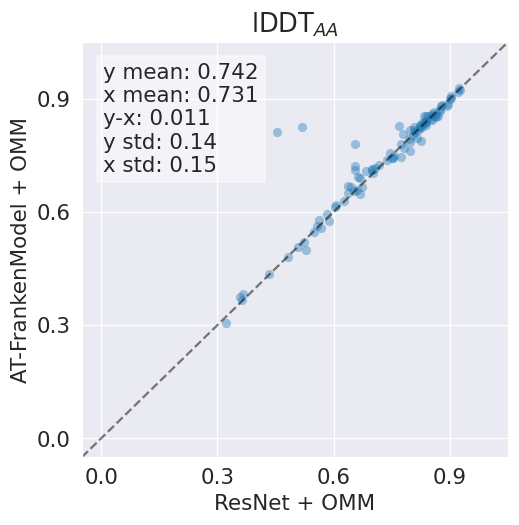

In [14]:
make_accuracy_plot(aim3A_dfs['ResNet + OMM']['test'],
                   aim3A_dfs['AT-FrankenModel + OMM']['test'],
                   'ResNet + OMM',
                   'AT-FrankenModel + OMM',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/frankenmodelomm_lddt',
                   color=_color,
                   alpha=.4)


<AxesSubplot:title={'center':'Clash Score'}, xlabel='AngleTransformer + OMM', ylabel='AT-FrankenModel + OMM'>

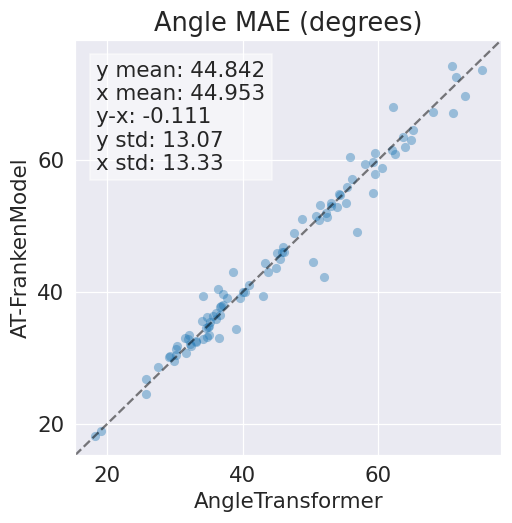

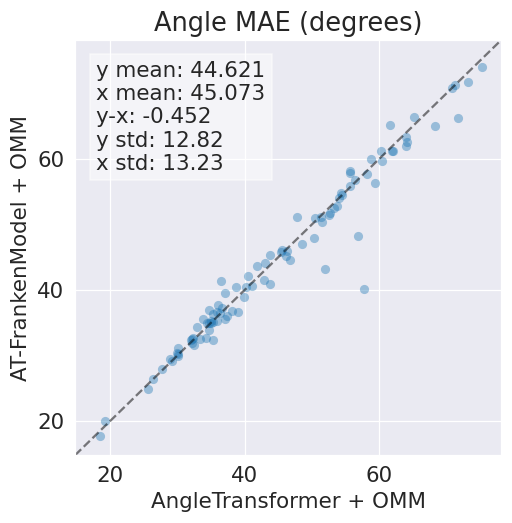

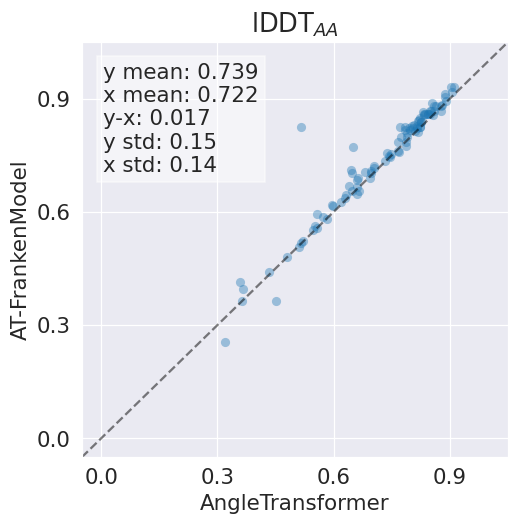

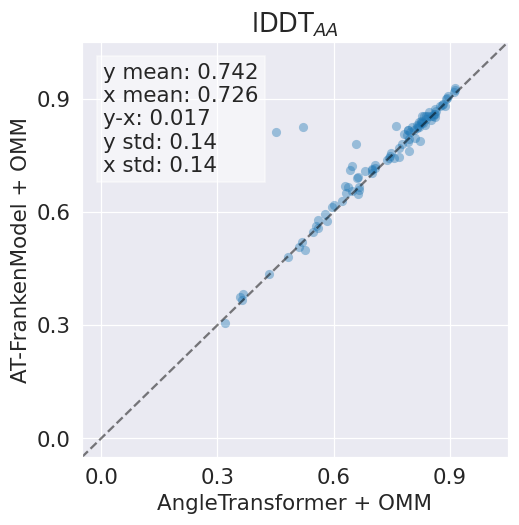

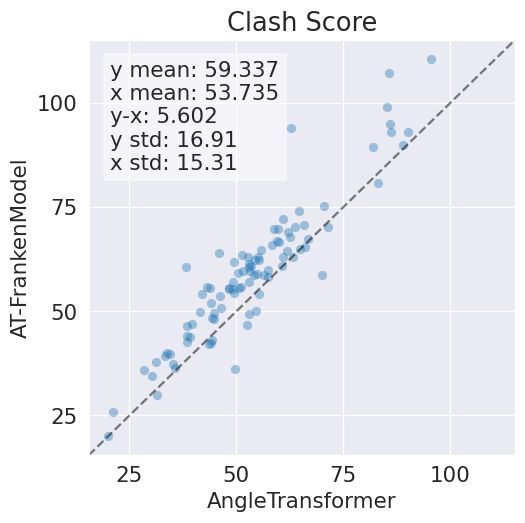

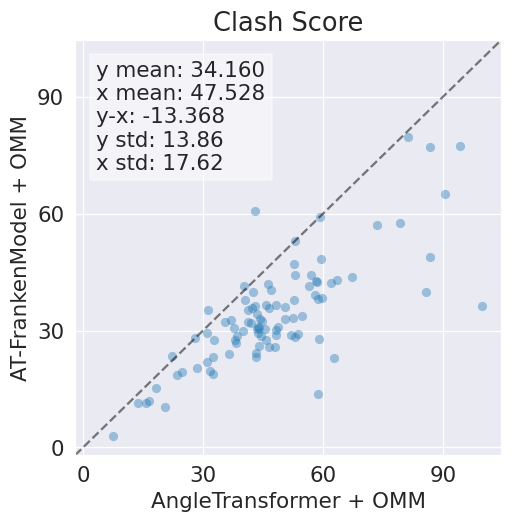

In [13]:
_color = "tab:blue"
make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['AT-FrankenModel']['test'],
                   'AngleTransformer',
                   'AT-FrankenModel',
                   "test",
                   metric='angle_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/frankenmodel_mae',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer + OMM']['test'],
                   aim3A_dfs['AT-FrankenModel + OMM']['test'],
                   'AngleTransformer + OMM',
                   'AT-FrankenModel + OMM',
                   "test",
                   metric='angle_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/frankenmodelomm_mae',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['AT-FrankenModel']['test'],
                   'AngleTransformer',
                   'AT-FrankenModel',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/frankenmodel_lddt',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer + OMM']['test'],
                   aim3A_dfs['AT-FrankenModel + OMM']['test'],
                   'AngleTransformer + OMM',
                   'AT-FrankenModel + OMM',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/frankenmodelomm_lddt',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet + OMM']['test'],
                   aim3A_dfs['AT-FrankenModel + OMM']['test'],
                   'ResNet + OMM',
                   'AT-FrankenModel + OMM',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/frankenmodelomm_lddt',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['AT-FrankenModel']['test'],
                   'AngleTransformer',
                   'AT-FrankenModel',
                   "test",
                   metric='clashscore',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/frankenmodel_clash',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer + OMM']['test'],
                   aim3A_dfs['AT-FrankenModel + OMM']['test'],
                   'AngleTransformer + OMM',
                   'AT-FrankenModel + OMM',
                   "test",
                   metric='clashscore',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/frankenmodelomm_clash',
                   color=_color,
                   alpha=.4)



<AxesSubplot:title={'center':'Angle MAE (degrees)'}, xlabel='AngleTransformer* + OMM', ylabel='ResNet* + OMM'>

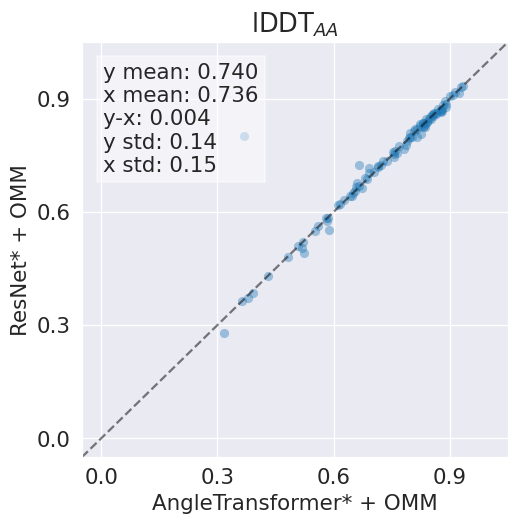

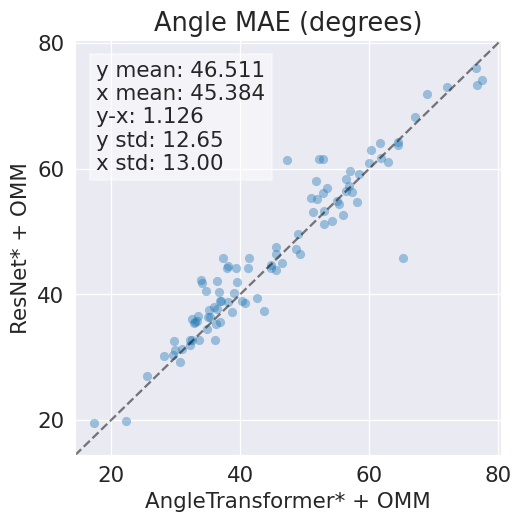

In [27]:
_color = "tab:blue"
make_accuracy_plot(aim3A_dfs['AngleTransformer* + OMM']['test'],
                   aim3A_dfs['ResNet* + OMM']['test'],
                   'AngleTransformer* + OMM',
                   'ResNet* + OMM',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/angle_mae_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer* + OMM']['test'],
                   aim3A_dfs['ResNet* + OMM']['test'],
                   'AngleTransformer* + OMM',
                   'ResNet* + OMM',
                   "test",
                   metric='angle_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/angle_mae_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

# make_accuracy_plot(aim3A_dfs['ResNet + OMM']['test'],
#                    aim3A_dfs['ResNet* + OMM']['test'],
#                    'ResNet + OMM',
#                    'ResNet* + OMM',
#                    "test",
#                    metric='lddt_aa',
#                    size=5,
#                    nbins=4,
#                    save_prefix='jk_research/evaluations/aim3c/figs/comparison/angle_mae_comparison_resnet_to_resnet',
#                    color=_color,
#                    alpha=.4)

# make_accuracy_plot(aim3A_dfs['ResNet + OMM']['test'],
#                    aim3A_dfs['ResNet* + OMM']['test'],
#                    'ResNet + OMM',
#                    'ResNet* + OMM',
#                    "test",
#                    metric='angle_mae',
#                    size=5,
#                    nbins=4,
#                    save_prefix='jk_research/evaluations/aim3c/figs/comparison/angle_mae_comparison_resnet_to_resnet',
#                    color=_color,
#                    alpha=.4)



<AxesSubplot:title={'center':'gdcall_aa'}, xlabel='AngleTransformer* + OMM', ylabel='ResNet* + OMM'>

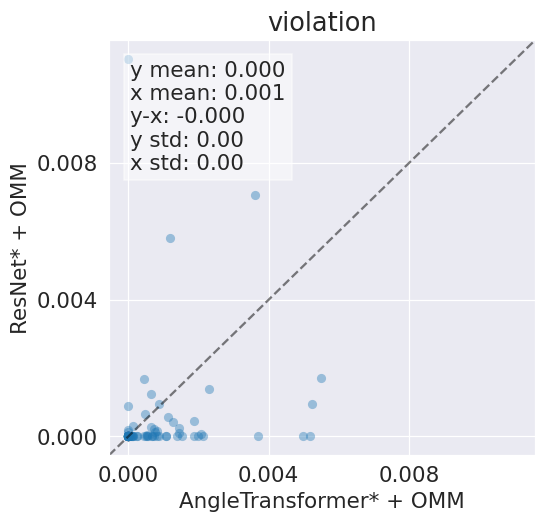

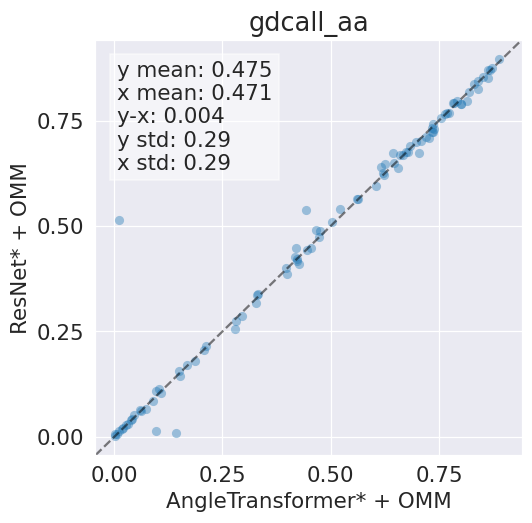

In [28]:
make_accuracy_plot(aim3A_dfs['AngleTransformer* + OMM']['test'],
                   aim3A_dfs['ResNet* + OMM']['test'],
                   'AngleTransformer* + OMM',
                   'ResNet* + OMM',
                   "test",
                   metric='violation',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/angle_mae_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer* + OMM']['test'],
                   aim3A_dfs['ResNet* + OMM']['test'],
                   'AngleTransformer* + OMM',
                   'ResNet* + OMM',
                   "test",
                   metric='gdcall_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/angle_mae_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

In [ ]:
_color = "tab:blue"
make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'AngleTransformer',
                   'AngleTransformer + OMM',
                   "test",
                   metric='angle_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/angle_mae_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet']['test'],
                   aim3A_dfs['ResNet + OMM']['test'],
                   'ResNet',
                   'ResNet + OMM',
                   "test",
                   metric='angle_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/angle_mae_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['ResNet']['test'],
                   'AngleTransformer',
                   'ResNet',
                   "test",
                   metric='angle_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/angle_mae_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer + OMM']['test'],
                   aim3A_dfs['ResNet + OMM']['test'],
                   'AngleTransformer + OMM',
                   'ResNet + OMM',
                   "test",
                   metric='angle_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/angle_mae_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)


<AxesSubplot:title={'center':'violation'}, xlabel='AngleTransformer', ylabel='AngleTransformer + OMM'>

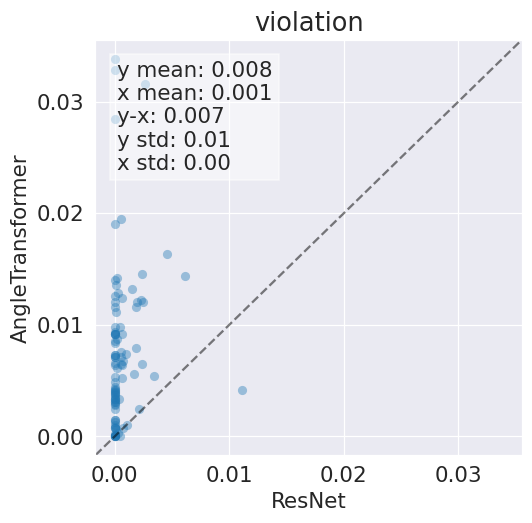

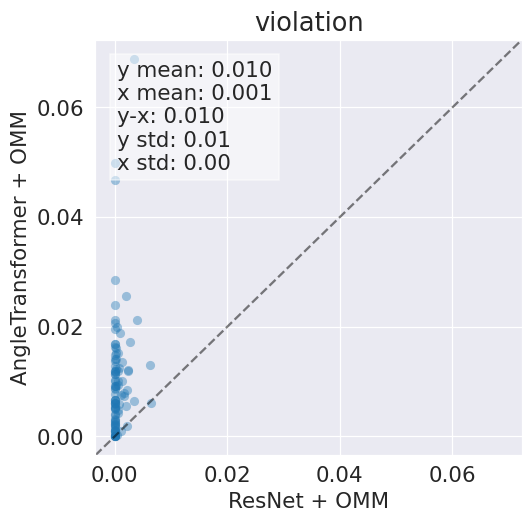

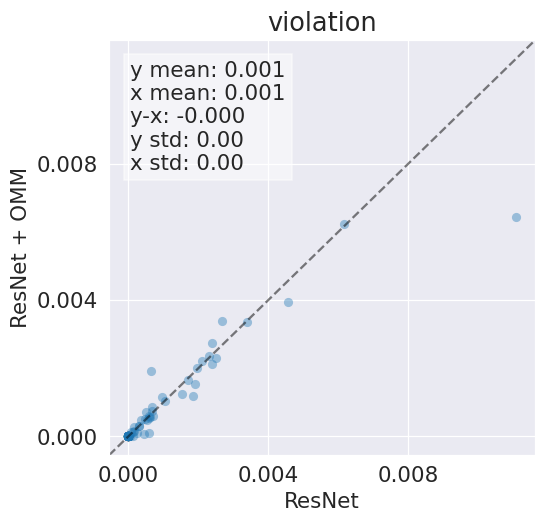

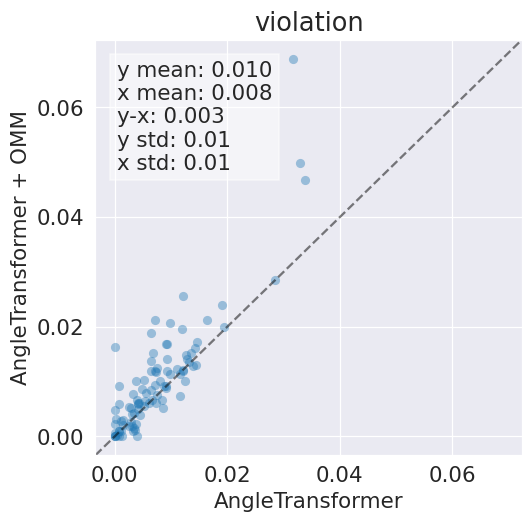

In [16]:
make_accuracy_plot(aim3A_dfs['ResNet']['test'],
                   aim3A_dfs['AngleTransformer']['test'],
                   'ResNet',
                   'AngleTransformer',
                   "test",
                   metric='violation',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet + OMM']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'ResNet + OMM',
                   'AngleTransformer + OMM',
                   "test",
                   metric='violation',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet']['test'],
                   aim3A_dfs['ResNet + OMM']['test'],
                   'ResNet',
                   'ResNet + OMM',
                   "test",
                   metric='violation',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'AngleTransformer',
                   'AngleTransformer + OMM',
                   "test",
                   metric='violation',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

In [ ]:
_color = "tab:blue"
make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'AngleTransformer',
                   'AngleTransformer + OMM',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet']['test'],
                   aim3A_dfs['ResNet + OMM']['test'],
                   'ResNet',
                   'ResNet + OMM',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['ResNet']['test'],
                   'AngleTransformer',
                   'ResNet',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer + OMM']['test'],
                   aim3A_dfs['ResNet + OMM']['test'],
                   'AngleTransformer + OMM',
                   'ResNet + OMM',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)


make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'AngleTransformer',
                   'AngleTransformer + OMM',
                   "test",
                   metric='violation',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'AngleTransformer',
                   'AngleTransformer + OMM',
                   "test",
                   metric='MolProbityScore',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'AngleTransformer',
                   'AngleTransformer + OMM',
                   "test",
                   metric='clashscore',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)


make_accuracy_plot(aim3A_dfs['AngleTransformer']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'AngleTransformer',
                   'AngleTransformer + OMM',
                   "test",
                   metric='clashscore',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['AngleTransformer + OMM']['test'],
                   aim3A_dfs['ResNet + OMM']['test'],
                   'AngleTransformer + OMM',
                   'ResNet + OMM',
                   "test",
                   metric='clashscore',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet']['test'],
                   aim3A_dfs['ResNet + OMM']['test'],
                   'ResNet',
                   'ResNet + OMM',
                   "test",
                   metric='clashscore',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet']['test'],
                   aim3A_dfs['AngleTransformer']['test'],
                   'ResNet',
                   'AngleTransformer',
                   "test",
                   metric='violation',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet + OMM']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'ResNet + OMM',
                   'AngleTransformer + OMM',
                   "test",
                   metric='violation',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet + OMM']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'ResNet + OMM',
                   'AngleTransformer + OMM',
                   "test",
                   metric='openmm_raw_energy',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet + OMM']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'ResNet + OMM',
                   'AngleTransformer + OMM',
                   "test",
                   metric='openmm_unscaled',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet + OMM']['test'],
                   aim3A_dfs['AngleTransformer + OMM']['test'],
                   'ResNet + OMM',
                   'AngleTransformer + OMM',
                   "test",
                   metric='openmm_scaled',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3c/figs/comparison/lddt_aa_comparison_resnet_to_resnet',
                   color=_color,
                   alpha=.4)



# make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
#                    aim3A_dfs['ResNet (AF2)']['test'],
#                    'ResNet (retrained)',
#                    'ResNet (AF2)',
#                    "test",
#                    metric='angle_mae',
#                    size=5,
#                    nbins=4,
#                    save_prefix='jk_research/evaluations/aim3a/figs/comparison/angle_mae_comparison_resnet_to_resnet',
#                    color=_color,
#                    alpha=.4,
#                    custom_title='Angle MAE (degrees)')

# make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
#                    aim3A_dfs['ResNet (AF2)']['test'],
#                    'ResNet (retrained)',
#                    'ResNet (AF2)',
#                    "test",
#                    metric='violation',
#                    size=5,
#                    nbins=4,
#                    save_prefix='jk_research/evaluations/aim3a/figs/comparison/violation_comparison_resnet_to_resnet',
#                    color=_color,
#                    alpha=.4,
#                    custom_title='Violation Loss')

# make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
#                    aim3A_dfs['ResNet (AF2)']['test'],
#                    'ResNet (retrained)',
#                    'ResNet (AF2)',
#                    "test",
#                    metric='x1_mae',
#                    size=5,
#                    nbins=4,
#                    save_prefix='jk_research/evaluations/aim3a/figs/comparison/x1_mae_comparison_resnet_to_resnet',
#                    color=_color,
#                    alpha=.4,
#                    custom_title='$X_1$ MAE (degrees)')

# make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
#                    aim3A_dfs['ResNet (AF2)']['test'],
#                    'ResNet (retrained)',
#                    'ResNet (AF2)',
#                    "test",
#                    metric='x2_mae',
#                    size=5,
#                    nbins=4,
#                    save_prefix='jk_research/evaluations/aim3a/figs/comparison/x2_mae_comparison_resnet_to_resnet',
#                    color=_color,
#                    alpha=.4,
#                    custom_title='$X_2$ MAE (degrees)')


In [ ]:
_color = "tab:red"
make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
                   aim3A_dfs['AngleTransformer']['test'],
                   'ResNet (retrained)',
                   'AngleTransformer',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3a/figs/comparison/lddt_aa_comparison_resnet_to_AT',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
                   aim3A_dfs['AngleTransformer']['test'],
                   'ResNet (retrained)',
                   'AngleTransformer',
                   "test",
                   metric='angle_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3a/figs/comparison/angle_mae_comparison_resnet_to_AT',
                   color=_color,
                   alpha=.4,
                   custom_title='Angle MAE (degrees)')

make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
                   aim3A_dfs['AngleTransformer']['test'],
                   'ResNet (retrained)',
                   'AngleTransformer',
                   "test",
                   metric='violation',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3a/figs/comparison/violation_comparison_resnet_to_AT',
                   color=_color,
                   alpha=.4,
                   custom_title='Violation Loss')

make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
                   aim3A_dfs['AngleTransformer']['test'],
                   'ResNet (retrained)',
                   'AngleTransformer',
                   "test",
                   metric='x1_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3a/figs/comparison/x1_mae_comparison_resnet_to_AT',
                   color=_color,
                   alpha=.4,
                   custom_title='$X_1$ MAE (degrees)')

# make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
#                    aim3A_dfs['AngleTransformer']['test'],
#                    'ResNet (retrained)',
#                    'AngleTransformer',
#                    "test",
#                    metric='x2_mae',
#                    size=5,
#                    nbins=4,
#                    save_prefix='jk_research/evaluations/aim3a/figs/comparison/x2_mae_comparison_resnet_to_AT',
#                    color=_color,
#                    alpha=.4,
#                    custom_title='$X_2$ MAE (degrees)')


In [ ]:
_color = "tab:purple"
make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
                   aim3A_dfs['AngleTransformer + Conv']['test'],
                   'ResNet (retrained)',
                   'AngleTransformerXL',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3a/figs/comparison/lddt_aa_comparison_resnet_to_ATconv',
                   color=_color,
                   alpha=.4)

make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
                   aim3A_dfs['AngleTransformer + Conv']['test'],
                   'ResNet (retrained)',
                   'AngleTransformerXL',
                   "test",
                   metric='angle_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3a/figs/comparison/angle_mae_comparison_resnet_to_ATconv',
                   color=_color,
                   alpha=.4,
                   custom_title='Angle MAE (degrees)')

make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
                   aim3A_dfs['AngleTransformer + Conv']['test'],
                   'ResNet (retrained)',
                   'AngleTransformerXL',
                   "test",
                   metric='violation',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3a/figs/comparison/violation_comparison_resnet_to_ATconv',
                   color=_color,
                   alpha=.4,
                   custom_title='Violation Loss')

make_accuracy_plot(aim3A_dfs['ResNet (retrained)']['test'],
                   aim3A_dfs['AngleTransformer + Conv']['test'],
                   'ResNet (retrained)',
                   'AngleTransformerXL',
                   "test",
                   metric='x1_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3a/figs/comparison/x1_mae_comparison_resnet_to_ATconv',
                   color=_color,
                   alpha=.4,
                   custom_title='$X_1$ MAE (degrees)')


In [ ]:
aim3A_dfs['ResNet (retrained)']['test']['angle_mae'].describe()

In [ ]:
aim3A_dfs['AngleTransformer']['test']['angle_mae'].describe()

In [ ]:
from scipy.stats import ttest_ind

print("Is AngleTransformer better than ResNet (retrained)?")

print(ttest_ind(aim3A_dfs['ResNet (retrained)']['test']['angle_mae'],
aim3A_dfs['AngleTransformer']['test']['angle_mae'],
 equal_var=False,
 alternative="greater"))


print(ttest_ind(pd.concat((aim3A_dfs['ResNet (retrained)']['test']['angle_mae'],
aim3A_dfs['ResNet (retrained)']['val']['angle_mae']),
axis=0),
pd.concat((aim3A_dfs['AngleTransformer']['test']['angle_mae'],
aim3A_dfs['AngleTransformer']['val']['angle_mae']),
axis=0),
    equal_var=False,
    alternative="greater"))

print("\nIs AngleTransformer better than ResNet (AF2)?")

print(ttest_ind(aim3A_dfs['ResNet (AF2)']['test']['angle_mae'],
aim3A_dfs['AngleTransformer']['test']['angle_mae'],
 equal_var=False,
 alternative="greater"))


print(ttest_ind(pd.concat((aim3A_dfs['ResNet (AF2)']['test']['angle_mae'],
aim3A_dfs['ResNet (AF2)']['val']['angle_mae']),
axis=0),
pd.concat((aim3A_dfs['AngleTransformer']['test']['angle_mae'],
aim3A_dfs['AngleTransformer']['val']['angle_mae']),
axis=0),
    equal_var=False,
    alternative="greater"))

print("\nIs AngleTransformer + Conv better than ResNet (retrained)?")

print(ttest_ind(aim3A_dfs['ResNet (retrained)']['test']['angle_mae'],
aim3A_dfs['AngleTransformer + Conv']['test']['angle_mae'],
 equal_var=False,
 alternative="greater"))


print(ttest_ind(pd.concat((aim3A_dfs['ResNet (retrained)']['test']['angle_mae'],
aim3A_dfs['ResNet (retrained)']['val']['angle_mae']),
axis=0),
pd.concat((aim3A_dfs['AngleTransformer + Conv']['test']['angle_mae'],
aim3A_dfs['AngleTransformer + Conv']['val']['angle_mae']),
axis=0),
    equal_var=False,
    alternative="greater"))


print("\nIs AngleTransformer + Conv better than ResNet (AF2)?")

print(ttest_ind(aim3A_dfs['ResNet (AF2)']['test']['angle_mae'],
aim3A_dfs['AngleTransformer + Conv']['test']['angle_mae'],
 equal_var=False,
 alternative="greater"))


print(ttest_ind(pd.concat((aim3A_dfs['ResNet (AF2)']['test']['angle_mae'],
aim3A_dfs['ResNet (AF2)']['val']['angle_mae']),
axis=0),
pd.concat((aim3A_dfs['AngleTransformer + Conv']['test']['angle_mae'],
aim3A_dfs['AngleTransformer + Conv']['val']['angle_mae']),
axis=0),
    equal_var=False,
    alternative="greater"))



In [ ]:
for metric in ["violation", "lddt_aa", "lddt_ca", "rmsd_aa", "angle_mae", "x1_mae", "x2_mae", "x3_mae", "x4_mae"]:
    make_nbarplot((aim3A_dfs['ResNet (AF2)']['test'],
                aim3A_dfs['ResNet (untrained)']['test'],
                aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],
                aim3A_dfs['AngleTransformer + Conv']['test'],),
                ('ResNet (AF2)',
                'ResNet (untrained)',
                'ResNet (retrained)',
                'AngleTransformer',
                'AngleTransformerXL'),
                metric,
                "test",
                dotsize=3,
                fliers=False,
                title_suffix="",
                save_prefix=f"jk_research/evaluations/aim3a/figs/{metric}_summary_test",
                swarm=True,
                violin=False)



    make_nbarplot((aim3A_dfs['ResNet (AF2)']['test'],
                aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],),
                ('ResNet (AF2)',
                'ResNet (retrained)',
                'AngleTransformer',),
                metric,
                "test",
                dotsize=3,
                fliers=False,
                title_suffix="",
                save_prefix=f"jk_research/evaluations/aim3a/figs/{metric}_summary_test_noconv",
                swarm=True,
                violin=False)

    make_nbarplot((aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],),
                ('ResNet (retrained)',
                'AngleTransformer',),
                metric,
                "test",
                dotsize=3,
                fliers=False,
                title_suffix="",
                save_prefix=f"jk_research/evaluations/aim3a/figs/{metric}_summary_test_noconv_noAF2",
                swarm=True,
                violin=False)
    make_nbarplot_vert((aim3A_dfs['ResNet (AF2)']['test'],
                aim3A_dfs['ResNet (untrained)']['test'],
                aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],
                aim3A_dfs['AngleTransformer + Conv']['test'],),
                ('ResNet (AF2)',
                'ResNet (untrained)',
                'ResNet (retrained)',
                'AngleTransformer',
                'AngleTransformerXL'),
                metric,
                "test",
                dotsize=3,
                fliers=False,
                title_suffix="",
                save_prefix=f"jk_research/evaluations/aim3a/figs/{metric}_vert_summary_test",
                swarm=True)

    make_nbarplot_vert((aim3A_dfs['ResNet (AF2)']['test'],
                aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],),
                ('ResNet (AF2)',
                'ResNet (retrained)',
                'AngleTransformer',),
                metric,
                "test",
                dotsize=3,
                fliers=False,
                title_suffix="",
                save_prefix=f"jk_research/evaluations/aim3a/figs/{metric}_vert_summary_test_noconv",
                swarm=True)

    make_nbarplot_vert((aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],),
                ('ResNet (retrained)',
                'AngleTransformer',),
                metric,
                "test",
                dotsize=3,
                fliers=False,
                title_suffix="",
                save_prefix=f"jk_research/evaluations/aim3a/figs/{metric}_vert_summary_test_noconv_noAF2",
                swarm=True)

In [ ]:

make_chi_angle_grouped_barplot([aim3A_dfs['ResNet (AF2)']['test'],
                aim3A_dfs['ResNet (untrained)']['test'],
                aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],
                aim3A_dfs['AngleTransformer + Conv']['test'],],
                ('ResNet (AF2)',
                'ResNet (untrained)',
                'ResNet (retrained)',
                'AngleTransformer',
                'AngleTransformerXL'),
                save_prefix=f"jk_research/evaluations/aim3a/figs/chi_angle_summary_test")

make_chi_angle_grouped_barplot([aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],],
                ('ResNet (retrained)',
                'AngleTransformer'),
                save_prefix=f"jk_research/evaluations/aim3a/figs/chi_angle_summary_test_noconv_noAF2")

make_chi_angle_grouped_barplot([aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer + Conv']['test'],],
                ('ResNet (retrained)',
                'AngleTransformerXL'),
                save_prefix=f"jk_research/evaluations/aim3a/figs/chi_angle_summary_test_wconv_noAF2")

In [ ]:
make_residue_type_grouped_plot([aim3A_dfs['ResNet (AF2)']['test'],
                aim3A_dfs['ResNet (untrained)']['test'],
                aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],
                aim3A_dfs['AngleTransformer + Conv']['test'],],
                ('ResNet (AF2)',
                'ResNet (untrained)',
                'ResNet (retrained)',
                'AngleTransformer',
                'AngleTransformerXL'),
                save_prefix=f"jk_research/evaluations/aim3a/figs/hydro_summary_test")

make_residue_type_grouped_plot([aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],],
                ('ResNet (retrained)',
                'AngleTransformer'),
                save_prefix=f"jk_research/evaluations/aim3a/figs/hydro_summary_test_noconv_noAF2")

make_residue_type_grouped_plot([aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer + Conv']['test'],],
                ('ResNet (retrained)',
                'AngleTransformerXL'),
                save_prefix=f"jk_research/evaluations/aim3a/figs/hydro_summary_test_wconv_noAF2")

In [ ]:
make_amino_acid_grouped_plot([aim3A_dfs['ResNet (AF2)']['test'],
                              aim3A_dfs['ResNet (untrained)']['test'],
                aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],
                aim3A_dfs['AngleTransformer + Conv']['test'],],
                ('ResNet (AF2)',
                'ResNet (untrained)',
                'ResNet (retrained)',
                'AngleTransformer',
                'AngleTransformerXL'),
                save_prefix=f"jk_research/evaluations/aim3a/figs/residue_identity_summary_test",
                size=1.5)

make_amino_acid_grouped_plot([aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],],
                ('ResNet (retrained)',
                'AngleTransformer'),
                save_prefix=f"jk_research/evaluations/aim3a/figs/residue_identity_summary_test_noconv_noAF2",
                size=2.5)

make_amino_acid_grouped_plot([aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer + Conv']['test'],],
                ('ResNet (retrained)',
                'AngleTransformerXL'),
                save_prefix=f"jk_research/evaluations/aim3a/figs/residue_identity_summary_test_wconv_noAF2",
                size=2.5)

In [ ]:

make_prediction_metrics_grouped_plot([aim3A_dfs['ResNet (AF2)']['test'],
                aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],
                aim3A_dfs['AngleTransformer + Conv']['test'],],
                ('ResNet (AF2)',
                'ResNet (retrained)',
                'AngleTransformer',
                'AngleTransformerXL'),
                save_prefix=f"jk_research/evaluations/aim3a/figs/groupmetrics_summary_test")

make_prediction_metrics_grouped_plot([aim3A_dfs['ResNet (retrained)']['test'],
                aim3A_dfs['AngleTransformer']['test'],],
                ('ResNet (retrained)',
                'AngleTransformer'),
                save_prefix=f"jk_research/evaluations/aim3a/figs/groupmetrics_summary_test_noconv_noAF2")

In [ ]:
from scipy.stats import ttest_ind

print(ttest_ind(aim3A_dfs['ResNet (retrained)']['test']['angle_mae'],
aim3A_dfs['AngleTransformer']['test']['angle_mae'],
 equal_var=False,
 alternative="greater"))

 # Repeat the above but concatenate the 'val' values to it

print(ttest_ind(pd.concat((aim3A_dfs['ResNet (retrained)']['test']['angle_mae'],
aim3A_dfs['ResNet (retrained)']['val']['angle_mae']),
axis=0),
pd.concat((aim3A_dfs['AngleTransformer']['test']['angle_mae'],
aim3A_dfs['AngleTransformer']['val']['angle_mae']),
axis=0),
    equal_var=False,
    alternative="greater"))



## 3B

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 110
# Make font size about 50% larger
mpl.rcParams['font.size'] = 12.75

In [ ]:
# ('eval_toastyC1', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
# ('eval_toastyN1', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
# ('eval_toastyRC1', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
# ('eval_toastyRC2', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
# ('eval_toastyC2', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
# ('eval_toastyRC3', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
# ('eval_toastyN2', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
# ('eval_toastyC3', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
# ('eval_toastyN3', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
# ('eval_toastyRN1', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
# ('eval_toastyRN2', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
# ('eval_toastyRN3', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
('eval_sunny-disco-172-g4gpu-extended-conv-4gpu-s1', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
('eval_sunny-disco-172-g4gpu-extended3-conv-4gpu', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
('eval_sunny-disco-172-g4gpu-extended2-conv-4gpu-s2', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
('eval_sunny-disco-172-g4gpu-extended', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
('eval_sunny-disco-172-g4gpu-extended2', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3B')
('eval_sunny-disco-172-g4gpu-extended3', '/net/pulsar/home/koes/jok120/openfold/out/evaluations/aim3')

## DF Defs

In [ ]:

dataframe_meta_dict ={}
dataframe_meta_dict["ResNet"] = {'seeds' : [{'name': 'eval_toastyRN1'}, {'name': 'eval_toastyRN2'}, {'name': 'eval_toastyRN3'}]}
dataframe_meta_dict['ResNet + Conv'] = {'seeds' : [{'name': 'eval_toastyRC1'}, {'name': 'eval_toastyRC2'}, {'name': 'eval_toastyRC3'}]}
dataframe_meta_dict['AngleTransformer'] = {'seeds' : [{'name': 'eval_toastyN1'}, {'name': 'eval_toastyN2'}, {'name': 'eval_toastyN3'}]}
dataframe_meta_dict['AngleTransformer + Conv'] = {'seeds' : [{'name': 'eval_toastyC1'}, {'name': 'eval_toastyC2'}, {'name': 'eval_toastyC3'}]}
dataframe_meta_dict['AngleTransformerXL'] = {'seeds' : [{'name': 'eval_sunny-disco-172-g4gpu-extended'}, {'name': 'eval_sunny-disco-172-g4gpu-extended2'}, {'name': 'eval_sunny-disco-172-g4gpu-extended3'}]}
dataframe_meta_dict['AngleTransformerXL + Conv'] = {'seeds' : [{'name': 'eval_sunny-disco-172-g4gpu-extended-conv-4gpu-s1'}, {'name': 'eval_sunny-disco-172-g4gpu-extended2-conv-4gpu-s2'}, {'name': 'eval_sunny-disco-172-g4gpu-extended3-conv-4gpu'}]}



In [ ]:
for runtype in dataframe_meta_dict.keys():
    print(runtype)
    for seed in range(3):
        model_name = dataframe_meta_dict[runtype]['seeds'][seed]['name']
        dataframe_meta_dict[runtype]['seeds'][seed]['test'] = df_dict[(model_name, 'test')]
        dataframe_meta_dict[runtype]['seeds'][seed]['val'] = df_dict[(model_name, 'val',)]

    dataframe_meta_dict[runtype]['combined'] = {
        'test':
        pd.concat((dataframe_meta_dict[runtype]['seeds'][0]['test'],
                   dataframe_meta_dict[runtype]['seeds'][1]['test'],
                   dataframe_meta_dict[runtype]['seeds'][2]['test']),
                  axis=0),
        'val':
        pd.concat((dataframe_meta_dict[runtype]['seeds'][0]['val'],
                   dataframe_meta_dict[runtype]['seeds'][1]['val'],
                   dataframe_meta_dict[runtype]['seeds'][2]['val']),
                  axis=0),
    }

dfs = dataframe_meta_dict

## Means for paper

In [ ]:
print("MolProbityScore, clashscore, lddt_aa, lddt_ca, tmscore_ca")
for modeltype in dfs.keys():
    print(modeltype, end="\n")
    for relax_type in ['test_pred', 'test_pred_relaxed']:
        df = dfs[modeltype]['seeds'][0][relax_type]
        print(f"{relax_type.replace('test_', '')}\t", end="")
        if "lddt_aa" in df.columns:
            print(f"{df['MolProbityScore'].mean():.3f}",
                  f"{df['clashscore'].mean():.3f}",
                  f"{df['lddt_aa'].mean():.3f}",
                  f"{df['lddt_ca'].mean():.3f}",
                  f"{df['tmscore_ca'].mean():.3f}",
                  end="\n")
        else:
            print(f"{df['MolProbityScore'].mean():.3f}",
                  f"{df['clashscore'].mean():.3f}",
                  end="\n")


In [ ]:
from scipy.stats import ttest_ind

print(ttest_ind(aim3A_dfs['ResNet (retrained)']['test']['angle_mae'],
aim3A_dfs['AngleTransformer']['test']['angle_mae'],
 equal_var=False,
 alternative="greater"))

 # Repeat the above but concatenate the 'val' values to it

print(ttest_ind(pd.concat((aim3A_dfs['ResNet (retrained)']['test']['angle_mae'],
aim3A_dfs['ResNet (retrained)']['val']['angle_mae']),
axis=0),
pd.concat((aim3A_dfs['AngleTransformer']['test']['angle_mae'],
aim3A_dfs['AngleTransformer']['val']['angle_mae']),
axis=0),
    equal_var=False,
    alternative="greater"))



In [ ]:
dfs['AF2']['combined']['test_pred']['MolProbityScore'].to_numpy(), dfs['AF2 + scnmin + OMM*']['combined']['test_pred']['MolProbityScore'].to_numpy()

In [ ]:
print(ttest_ind(dfs['AF2']['combined']['test_pred']['clashscore'], dfs['AF2 + scnmin + OMM*']['combined']['test_pred']['clashscore'], equal_var=False, alternative="greater"))
print(ttest_ind(dfs['AF2']['combined']['test_pred']['MolProbityScore'].dropna(), dfs['AF2 + scnmin + OMM*']['combined']['test_pred']['MolProbityScore'].dropna(), equal_var=False, alternative="greater", nan_policy="omit"))
print(ttest_ind(dfs['AF2']['combined']['test_pred']['lddt_aa'].dropna(), dfs['AF2 + scnmin + OMM*']['combined']['test_pred']['lddt_aa'].dropna(), equal_var=False, alternative="greater", nan_policy="omit"))

In [ ]:
dfs['AF2']['combined']['test_pred'].columns

In [ ]:
baseline_target = dfs['AF2']['combined']

for metric in ['MolProbityScore', 'clashscore', 'openmm_unscaled', "openmm_raw_energy", 'lddt_aa']:
    for relax_state in ['test_pred', 'test_pred_relaxed']:
        print("Metric:", metric,  "| Relax state:", relax_state)
        if metric in ['lddt_aa', 'openmm_unscaled', "openmm_raw_energy"] and metric not in baseline_target[relax_state]:
            continue
        x = baseline_target[relax_state][metric]
        for comparison in ['AF2 + scnmin', 'AF2 + OMM', 'AF2 + scnmin + OMM', 'AF2 + scnmin + OMM*']:
            print("     Comparison:", comparison)
            y = dfs[comparison]['combined'][relax_state][metric]
            p_val = ttest_ind(y.dropna(), x.dropna(), equal_var=False, alternative='less').pvalue
            print("         p-value:", "{:.0e}".format(p_val))
            if 'openmm_raw' in metric:
                print(f"        {metric}: {dfs[comparison]['combined'][relax_state][metric].median():.1e}")
            elif 'openmm_unscaled' in metric:
                print(f"        {metric}: {dfs[comparison]['combined'][relax_state][metric].median():.3f}")


## Acc plots

#### Openmm / Energy

In [ ]:
metric = 'clashscore'
state = 'test_pred_relaxed'
# state = 'test_pred'
for s in range(3):
    make_nbarplot((dfs['AF2']['seeds'][s][state],
                dfs['AF2 + scnmin']['seeds'][s][state],
                dfs['AF2 + OMM']['seeds'][s][state],
                dfs['AF2 + scnmin + OMM']['seeds'][s][state],
                dfs['AF2 + scnmin + OMM*']['seeds'][s][state],),
                ('AF2',
                'AF2 + scnmin',
                'AF2 + OMM',
                'AF2 + scnmin + OMM',
                'AF2 + scnmin + OMM*',),
                metric,
                "test",
                dotsize=1.5,
                fliers=False,
                title_suffix="",
                save_prefix="openmm_UR",
                swarm=True,
                violin=False)


In [ ]:
make_nbarplot((dfs['ResNet']['combined']['test'],
               dfs['ResNet + Conv']['combined']['test'],
               dfs['AngleTransformer']['combined']['test'],
               dfs['AngleTransformer + Conv']['combined']['test'],
               dfs['AngleTransformerXL']['combined']['test'],
               dfs['AngleTransformerXL + Conv']['combined']['test']),
              ('ResNet',
              'ResNet + Conv',
              'AngleTransformer',
              'AngleTransformer + Conv',
              'AngleTransformerXL',
              'AngleTransformerXL + Conv',),
              "angle_mae",
              "test",
              dotsize=1.5,
              fliers=False,
              title_suffix="",
              save_prefix="jk_research/evaluations/aim3b/figs/combined/angle_mae_combined_test",
              swarm=True,
              violin=False)

make_nbarplot((dfs['ResNet']['combined']['val'],
               dfs['ResNet + Conv']['combined']['val'],
               dfs['AngleTransformer']['combined']['val'],
               dfs['AngleTransformer + Conv']['combined']['val'],),
              ('ResNet',
              'ResNet + Conv',
              'AngleTransformer',
              'AngleTransformer + Conv',),
              "angle_mae",
              "validation",
              dotsize=1.5,
              fliers=False,
              title_suffix="",
              save_prefix="jk_research/evaluations/aim3b/figs/combined/angle_mae_combined_val",
              swarm=True,
              violin=False)

# make_nbarplot((dfs['ResNet']['combined']['test'],
#                dfs['ResNet + Conv']['combined']['test'],
#                dfs['AngleTransformer']['combined']['test'],
#                dfs['AngleTransformer + Conv']['combined']['test'],),
#               ('ResNet',
#               'ResNet + Conv',
#               'AngleTransformer',
#               'AngleTransformer + Conv',),
#               "x1_mae",
#               "test",
#               dotsize=1.5,
#               fliers=False,
#               title_suffix="",
#               save_prefix="x1_mae_combined_test",
#               swarm=True,
#               violin=False)

make_nbarplot((dfs['ResNet']['combined']['test'],
               dfs['ResNet + Conv']['combined']['test'],
               dfs['AngleTransformer']['combined']['test'],
               dfs['AngleTransformer + Conv']['combined']['test'],),
              ('ResNet',
              'ResNet + Conv',
              'AngleTransformer',
              'AngleTransformer + Conv',),
              "lddt_aa",
              "test",
              dotsize=1.5,
              fliers=False,
              title_suffix="",
              save_prefix="jk_research/evaluations/aim3b/figs/combined/lddt_aa_combined_test",
              swarm=True,
              violin=False)

for chi in ['x1', 'x2', 'x3', 'x4']:
    make_nbarplot((dfs['ResNet']['combined']['test'],
                dfs['ResNet + Conv']['combined']['test'],
                dfs['AngleTransformer']['combined']['test'],
                dfs['AngleTransformer + Conv']['combined']['test'],),
                ('ResNet',
                'ResNet + Conv',
                'AngleTransformer',
                'AngleTransformer + Conv',),
                f"{chi}_mae",
                "test",
                dotsize=1.5,
                fliers=False,
                title_suffix="",
                save_prefix=f"jk_research/evaluations/aim3b/figs/combined/{chi}_mae_combined_test",
                swarm=True,
                violin=False)

# make_nbarplot((dfs['ResNet']['combined']['test'],
#                dfs['ResNet + Conv']['combined']['test'],
#                dfs['AngleTransformer']['combined']['test'],
#                dfs['AngleTransformer + Conv']['combined']['test'],),
#               ('ResNet',
#               'ResNet + Conv',
#               'AngleTransformer',
#               'AngleTransformer + Conv',),
#               "x2_mae",
#               "test",
#               dotsize=1.5,
#               fliers=False,
#               title_suffix="",
#               save_prefix="x2_mae_combined_test",
#               swarm=True,
#               violin=False)

for amino_acid_residue_3letter_code in ['CYS', 'ASP', 'GLU', 'PHE', 'TYR', 'HIS', 'LYS', 'ARG', 'SER', 'THR', 'ASN', 'GLN', 'PRO', 'VAL', 'ILE', 'LEU', 'MET', 'TRP']:
    make_nbarplot((dfs['ResNet']['combined']['test'],
                dfs['ResNet + Conv']['combined']['test'],
                dfs['AngleTransformer']['combined']['test'],
                dfs['AngleTransformer + Conv']['combined']['test'],),
                ('ResNet',
                'ResNet + Conv',
                'AngleTransformer',
                'AngleTransformer + Conv',),
                f"{amino_acid_residue_3letter_code}_mae",
                "test",
                dotsize=1.5,
                fliers=False,
                title_suffix="",
                save_prefix=f"jk_research/evaluations/aim3b/figs/combined/{amino_acid_residue_3letter_code}_mae_combined_test",
                swarm=True,
                violin=False)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_grouped_plot(dataframes, model_names, metric, plot_title, save_prefix="", dotsize=1.5, fliers=False, swarm=True):
    """
    Generate a grouped box and swarm plot.
    
    Parameters:
    - dataframes: List of DataFrames containing the prediction data.
    - model_names: List of model names corresponding to the DataFrames.
    - metric: The column in the dataframe to plot (e.g., "angle_mae").
    - plot_title: Title for the plot.
    - save_prefix: Prefix for saving the plot.
    - dotsize: Size of the dots in the swarm plot.
    - fliers: Whether to show fliers in the box plot.
    - swarm: Whether to overlay a swarm plot.
    """
    
    # Extract the specified metric and assign model name and Conv layer info
    dfs = []
    for df, model in zip(dataframes, model_names):
        df_temp = df.copy()  # Avoid modifying the original dataframe
        base_model_name = model.replace(" + Conv", "")
        df_temp['BaseModel'] = base_model_name
        df_temp['ConvLayer'] = '+ Conv' if '+ Conv' in model else 'No Conv'
        df_temp = df_temp[['BaseModel', 'ConvLayer', metric]]
        dfs.append(df_temp)

    # Combine data
    combined_data = pd.concat(dfs, axis=0)

    # Create the plots
    plt.figure(figsize=(12, 8))
    
    # Box plot
    sns.boxplot(x='BaseModel', y=metric, hue='ConvLayer', data=combined_data, showfliers=fliers)  

    # Swarm plot
    if swarm:
        ax = sns.swarmplot(x='BaseModel', y=metric, hue='ConvLayer', data=combined_data, dodge=True, size=dotsize, color='black')
        
        # Handle the legend
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles[:2], labels[:2], title='Conv Layer')  # Adjust this if the number of ConvLayer categories changes

    plt.ylabel(metric)
    plt.xlabel("")
    plt.title(plot_title)
    
    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
make_grouped_plot(
    dataframes=[dfs['ResNet']['combined']['test'],
                dfs['ResNet + Conv']['combined']['test'],
                dfs['AngleTransformer']['combined']['test'],
                dfs['AngleTransformer + Conv']['combined']['test'],
                dfs['AngleTransformerXL']['combined']['test'],
                dfs['AngleTransformerXL + Conv']['combined']['test']],
    model_names=['ResNet', 'ResNet + Conv', 'AngleTransformer', 'AngleTransformer + Conv', 'AngleTransformerXL', 'AngleTransformerXL + Conv'],
    metric="angle_mae",
    plot_title="Angle MAE by Model and Conv Layer Usage",
    dotsize=3
)

make_grouped_plot(
    dataframes=[aim3A_dfs['ResNet (AF2)']['test'],
                aim3A_dfs['ResNet (untrained)']['test'],
        dfs['ResNet']['combined']['test'],
                dfs['ResNet + Conv']['combined']['test'],
                dfs['AngleTransformer']['combined']['test'],
                dfs['AngleTransformer + Conv']['combined']['test'],
                dfs['AngleTransformerXL']['combined']['test'],
                dfs['AngleTransformerXL + Conv']['combined']['test']],
    model_names=['ResNet (AF2)', 'ResNet (untrained)', 'ResNet (retrained)', 'ResNet (retrained) + Conv', 'AngleTransformer', 'AngleTransformer + Conv', 'AngleTransformerXL', 'AngleTransformerXL + Conv'],
    metric="angle_mae",
    plot_title="Angle MAE by Model and Conv Layer Usage",
    dotsize=3
)

In [ ]:
make_grouped_plot(
    dataframes=[dfs['ResNet']['combined']['test'],
                dfs['ResNet + Conv']['combined']['test'],
                dfs['AngleTransformer']['combined']['test'],
                dfs['AngleTransformer + Conv']['combined']['test'],
                dfs['AngleTransformerXL']['combined']['test'],
                dfs['AngleTransformerXL + Conv']['combined']['test']],
    model_names=['ResNet', 'ResNet + Conv', 'AngleTransformer', 'AngleTransformer + Conv', 'AngleTransformerXL', 'AngleTransformerXL + Conv'],
    metric="lddt_aa",
    plot_title="lDDT$_{AA}$ by Model and Conv Layer Usage",
    dotsize=3
)

make_grouped_plot(
    dataframes=[aim3A_dfs['ResNet (AF2)']['test'],
                aim3A_dfs['ResNet (untrained)']['test'],
        dfs['ResNet']['combined']['test'],
                dfs['ResNet + Conv']['combined']['test'],
                dfs['AngleTransformer']['combined']['test'],
                dfs['AngleTransformer + Conv']['combined']['test'],
                dfs['AngleTransformerXL']['combined']['test'],
                dfs['AngleTransformerXL + Conv']['combined']['test']],
    model_names=['ResNet (AF2)', 'ResNet (untrained)', 'ResNet (retrained)', 'ResNet (retrained) + Conv', 'AngleTransformer', 'AngleTransformer + Conv', 'AngleTransformerXL', 'AngleTransformerXL + Conv'],
    metric="lddt_aa",
    plot_title="lDDT$_{AA}$ by Model and Conv Layer Usage",
    dotsize=3
)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_chi_angles_by_conv(dataframes, model_names, save_prefix="", dotsize=3):
    # Pre-process the data
    combined_data = pd.concat(
        [df.assign(Model=model) for df, model in zip(dataframes, model_names)],
        axis=0
    )
    melted_data = combined_data.melt(id_vars=['Model'], 
                                     value_vars=['angle_mae', 'x1_mae', 'x2_mae', 'x3_mae', 'x4_mae'], 
                                     var_name="$X_i$", value_name='mae')
    
    # Determine Convolutional status
    melted_data["ConvStatus"] = melted_data["Model"].apply(lambda x: "+ Conv" if "+ Conv" in x else "No Conv")

    # Create the plot
    plt.figure(figsize=(15, 8))
    sns.barplot(x="Model", y="mae", hue="$X_i$", data=melted_data, ci=None, palette="rocket", dodge=True)
    
    # Add swarmplot on top
    sns.swarmplot(x="Model", y="mae", hue="$X_i$", data=melted_data, dodge=True, size=dotsize, color="black", alpha=0.8)
    
    # Modify legend to hide swarmplot markers and show only unique entries
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels, new_handles = [], []
    for handle, label in zip(handles, labels):
        if label not in new_labels:
            new_labels.append(label)
            new_handles.append(handle)
    plt.legend(new_handles, new_labels, title="$X_i$")
    
    plt.title('Model Performance by Chi Angles and Convolutional Status')
    plt.ylabel('Mean Absolute Error (degrees)')
    plt.xlabel("Model")
    
    if save_prefix:
        plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:

_angles_by_conv(
    dataframes=[
        dfs['ResNet']['combined']['test'],
        dfs['ResNet + Conv']['combined']['test'],
        dfs['AngleTransformer']['combined']['test'],
        dfs['AngleTransformer + Conv']['combined']['test'],
        dfs['AngleTransformerXL']['combined']['test'],
        dfs['AngleTransformerXL + Conv']['combined']['test']
    ],
    model_names=[
        'ResNet',
        'ResNet + Conv',
        'AngleTransformer',
        'AngleTransformer + Conv',
        'AngleTransformerXL',
        'AngleTransformerXL + Conv'
    ],
    save_prefix="jk_research/evaluations/aim3b/figs/chi_angles_conv_summary",
    dotsize=1.5,
)


In [ ]:
make_accuracy_plot(dfs['ResNet']['combined']['test'],
                   dfs['AngleTransformer']['combined']['test'],
                   'ResNet',
                   'AngleTransformer',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3b/figs/comparison/lddt_aa_comparison_RNAT',
                   color='tab:purple',
                   alpha=.3)

make_accuracy_plot(dfs['ResNet']['combined']['test'],
                   dfs['AngleTransformerXL + Conv']['combined']['test'],
                   'ResNet',
                   'AngleTransformerXL + Conv',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3b/figs/comparison/lddt_aa_comparison_RNAT',
                   color='tab:purple',
                   alpha=.3)

make_accuracy_plot(dfs['ResNet']['combined']['test'],
                   dfs['AngleTransformer']['combined']['test'],
                   'ResNet',
                   'AngleTransformer',
                   "test",
                   metric='rmsd_aa',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3b/figs/comparison/rmsd_aa_comparison_RNAT',
                   color='tab:purple',
                   alpha=.3)


make_accuracy_plot(dfs['ResNet']['combined']['test'],
                   dfs['AngleTransformer']['combined']['test'],
                   'ResNet',
                   'AngleTransformer',
                   "test",
                   metric='angle_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3b/figs/comparison/angle_mae_comparison_RNAT',
                   color='tab:purple',
                   alpha=.3)

make_accuracy_plot(dfs['ResNet']['combined']['test'],
                   dfs['AngleTransformer']['combined']['test'],
                   'ResNet',
                   'AngleTransformer',
                   "test",
                   metric='x1_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3b/figs/comparison/x1_mae_comparison_RNAT',
                   color='tab:purple',
                   alpha=.3)

make_accuracy_plot(dfs['ResNet']['combined']['test'],
                   dfs['AngleTransformer']['combined']['test'],
                   'ResNet',
                   'AngleTransformer',
                   "test",
                   metric='x2_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3b/figs/comparison/x2_mae_comparison_RNAT',
                   color='tab:purple',
                   alpha=.3)

make_accuracy_plot(dfs['ResNet']['combined']['test'],
                   dfs['AngleTransformer']['combined']['test'],
                   'ResNet',
                   'AngleTransformer',
                   "test",
                   metric='x3_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3b/figs/comparison/x3_mae_comparison_RNAT',
                   color='tab:purple',
                   alpha=.3)

make_accuracy_plot(dfs['ResNet']['combined']['test'],
                   dfs['AngleTransformer']['combined']['test'],
                   'ResNet',
                   'AngleTransformer',
                   "test",
                   metric='x4_mae',
                   size=5,
                   nbins=4,
                   save_prefix='jk_research/evaluations/aim3b/figs/comparison/x4_mae_comparison_RNAT',
                   color='tab:purple',
                   alpha=.3)



In [ ]:
make_accuracy_plot(dfs['AF2']['combined']['test_pred'],
                   dfs['AF2 + scnmin']['combined']['test_pred'],
                   'AF2',
                   'AF2 + scnmin',
                   "test",
                   metric='openmm',
                   size=5,
                   nbins=4,
                   save_prefix='openmm_sq',
                   color='tab:purple',
                   alpha=.3)


make_accuracy_plot(dfs['AF2']['combined']['test_pred'],
                   dfs['AF2 + scnmin']['combined']['test_pred'],
                   'AF2',
                   'AF2 + scnmin',
                   "test",
                   metric='openmm',
                   size=5,
                   nbins=4,
                   save_prefix='openmm_scnmin_sq',
                   color='tab:purple',
                   alpha=.3)

# make_accuracy_plot(dfs['AF2 + scnmin']['combined']['test_pred'],
#                    dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
#                    'AF2 + scnmin',
#                    'AF2 + scnmin + OMM*',
#                    "test",
#                    metric='openmm',
#                    size=5,
#                    nbins=4,
#                    save_prefix='openmm_sq_scnmin',
#                    color='tab:purple',
#                    alpha=.7)



#### Structural Accuracy

In [ ]:
make_accuracy_plot(dfs['AF2']['combined']['test_pred'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
                   'AF2',
                   'AF2 + scnmin + OMM*',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   alpha=.2,
                   save_prefix='lddt_aa',
                   nbins=5,
                   color='tab:purple',)

make_accuracy_plot(dfs['AF2 + scnmin']['combined']['test_pred'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
                   'AF2 + scnmin',
                   'AF2 + scnmin + OMM*',
                   "test",
                   metric='lddt_aa',
                   size=5,
                   alpha=.5,
                   save_prefix='lddt_aa_scnmin',
                   nbins=5,
                   color='tab:purple',)

make_nbarplot((dfs['AF2']['combined']['test_pred'],
               dfs['AF2 + scnmin']['combined']['test_pred'],
               dfs['AF2 + OMM']['combined']['test_pred'],
               dfs['AF2 + scnmin + OMM']['combined']['test_pred'],
               dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],),
              ('AF2',
              'AF2 + scnmin',
              'AF2 + OMM',
              'AF2 + scnmin + OMM',
              'AF2 + scnmin + OMM*',),
              "lddt_aa",
              "test",
              dotsize=2,
              fliers=False,
              title_suffix="",
              save_prefix="lddt_aa_bar",
              swarm=True,
              violin=False)


In [ ]:
make_accuracy_plot(dfs['AF2 + scnmin']['combined']['test_pred'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
                   'AF2 + scnmin',
                   'AF2 + scnmin + OMM*',
                   "test",
                   metric='lddt_ca',
                   size=5,
                   alpha=.5,
                   save_prefix='lddt_ca',
                   nbins=5,
                   color='tab:purple',)

make_nbarplot((dfs['AF2']['combined']['test_pred'],
               dfs['AF2 + scnmin']['combined']['test_pred'],
               dfs['AF2 + OMM']['combined']['test_pred'],
               dfs['AF2 + scnmin + OMM']['combined']['test_pred'],
               dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],),
              ('AF2',
              'AF2 + scnmin',
              'AF2 + OMM',
              'AF2 + scnmin + OMM',
              'AF2 + scnmin + OMM*',),
              "lddt_ca",
              "test",
              dotsize=2,
              fliers=False,
              title_suffix="",
              save_prefix="clash_UR",
              swarm=True,
              violin=False)


In [ ]:
dfs['AF2 + scnmin']['combined']['test_pred'].columns

In [ ]:
make_accuracy_plot(dfs['AF2 + scnmin']['combined']['test_pred'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
                   'AF2 + scnmin',
                   'AF2 + scnmin + OMM*',
                   "test",
                   metric='gdtha_ca',
                   size=5,
                   alpha=.5,
                   save_prefix='gdtts_ca',
                   nbins=5,
                   color='tab:purple',)


In [ ]:
make_accuracy_plot(dfs['AF2 + scnmin']['combined']['test_pred'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
                   'AF2 + scnmin',
                   'AF2 + scnmin + OMM*',
                   "test",
                   metric='violation',
                   size=5,
                   alpha=.5,
                   save_prefix='gdtts_ha',
                   nbins=5,
                   color='tab:purple',)

make_nbarplot((dfs['AF2']['combined']['test_pred'],
               dfs['AF2 + scnmin']['combined']['test_pred'],
               dfs['AF2 + OMM']['combined']['test_pred'],
               dfs['AF2 + scnmin + OMM']['combined']['test_pred'],
               dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],),
              ('AF2',
              'AF2 + scnmin',
              'AF2 + OMM',
              'AF2 + scnmin + OMM',
              'AF2 + scnmin + OMM*',),
              "violation",
              "test",
              dotsize=2,
              fliers=False,
              title_suffix="",
              save_prefix="clash_UR",
              swarm=True,
              violin=False)

In [ ]:
make_accuracy_plot(dfs['AF2']['combined']['test_pred'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
                   'AF2',
                   'AF2 + scnmin + OMM*',
                   "test",
                   metric='openmm_raw_energy',
                   size=5,
                   alpha=.5,
                   save_prefix='raw_energy',
                   nbins=5,
                   color='tab:purple')


In [ ]:
make_accuracy_plot(dfs['AF2']['combined']['test_pred'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
                   'AF2',
                   'AF2 + scnmin + OMM*',
                   "test",
                   metric='rmsd_aa',
                   size=5,
                   alpha=.5,
                   save_prefix='gdtts_ha',
                   nbins=5,
                   color='tab:purple')


In [ ]:
make_accuracy_plot(dfs['AF2']['combined']['test_pred'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
                   'AF2',
                   'AF2 + scnmin + OMM*',
                   "test",
                   metric='gdtts_ca',
                   size=5,
                   alpha=.5,
                   save_prefix='gdtts_ha',
                   nbins=5,
                   color='tab:purple')


In [ ]:
make_accuracy_plot(dfs['AF2']['combined']['test_pred'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
                   'AF2',
                   'AF2 + scnmin + OMM*',
                   "test",
                   metric='sq_chi_loss',
                   size=5,
                   alpha=.3,
                   save_prefix='sq_chi_loss',
                   nbins=5,
                   color='tab:purple')


In [ ]:
make_accuracy_plot(dfs[0], dfs[2], df_names[0], df_names[2], "test", metric='tmscore_ca', size=5)

In [ ]:
# get the 5th default color from seaborn
color = sns.color_palette()[4]

#### Clashscore

In [ ]:
dfs['AF2 + OMM']['combined']['test_pred']['clashscore'].head()

In [ ]:
dfs['AF2']['combined']['test_pred']['clashscore'].head()

In [ ]:
dfs['AF2 + scnmin + OMM*']['combined']['test_pred']['clashscore'].head()

In [ ]:
make_accuracy_plot(dfs['AF2']['combined']['test_pred'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
                   'AF2',
                   'AF2 + scnmin + OMM*',
                   "test",
                   metric='clashscore',
                   size=5,
                   nbins=6,
                   save_prefix='clash_sq_UR',
                   custom_title='Clash Score (Unrelaxed Predictions)',
                   color='tab:purple',
                   alpha=.3)


In [ ]:
make_accuracy_plot(dfs[0], dfs[-2], df_names[0], df_names[-2], "test", metric='clashscore', size=5, nbins=6, save_prefix='clash_sq_UR', custom_title='Clash Score (Unrelaxed Structures)', color=color)

In [ ]:
make_accuracy_plot(dfs['AF2']['combined']['test_pred_relaxed'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred_relaxed'],
                   'AF2',
                   'AF2 + scnmin + OMM*',
                   "test",
                   metric='clashscore',
                   size=5,
                   nbins=6,
                   save_prefix='clash_sq_R',
                   custom_title='Clash Score (Relaxed Predictions)',
                   color='tab:purple',
                   alpha=0.3)


In [ ]:
make_accuracy_plot(dfs[0], dfs[-2], df_names[0], df_names[-2], "test", metric='clashscore', size=5)

In [ ]:
make_accuracy_plot(dfs[1], dfs[-1], df_names[1], df_names[-1], "test", metric='clashscore', size=5)

In [ ]:
make_accuracy_plot(dfs[3], dfs[5], df_names[3], df_names[5], "test", metric='MolProbityScore', size=5)

In [ ]:
make_accuracy_plot(dfs[3], dfs[5], df_names[3], df_names[5], "test", metric='clashscore', size=5)

In [ ]:
make_accuracy_plot(dfs[1], dfs[-3], df_names[1], df_names[-3], "test", metric='clashscore', size=5)

In [ ]:
make_accuracy_plot(dfs[1], dfs[-1], df_names[1], df_names[-1], "test", metric='clashscore', size=5)

In [ ]:
make_accuracy_plot(dfs[1], dfs[-1], df_names[1], df_names[-1], "test", metric='clashscore', size=5, )

In [ ]:
make_accuracy_plot(dfs['AF2']['combined']['test_pred'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],
                   'AF2',
                   'AF2 + scnmin + OMM*', "test", metric='MolProbityScore', size=5, color='tab:purple', alpha=0.7)

In [ ]:
make_accuracy_plot(dfs['AF2']['combined']['test_pred_relaxed'],
                   dfs['AF2 + scnmin + OMM*']['combined']['test_pred_relaxed'],
                   'AF2',
                   'AF2 + scnmin + OMM*', "test", metric='MolProbityScore', size=5, color='tab:purple', alpha=0.7)

In [ ]:
make_accuracy_plot(dfs[1], dfs[-1], df_names[1], df_names[-1], "test", metric='Mol_pct_rank', size=5)

In [ ]:
make_accuracy_plot(dfs[1], dfs[-1], df_names[1], df_names[-1], "test", metric='pct_rank', size=5)

## Summary Plots

In [ ]:
df = make_ngroupedbarplot(dfs_unrelaxed, df_names_unrelaxed, "pct_rank", "test", dotsize=3, do_swarm=False)

In [ ]:
df = make_ngroupedbarplot(dfs, df_names, "clashscore", "test", dotsize=3)

In [ ]:
df = make_ngroupedbarplot_vert(dfs, df_names, "MolProbityScore", "test", dotsize=3, do_swarm=False)

In [ ]:
df = make_ngroupedbarplot_vert(dfs, df_names, "clashscore", "test", dotsize=3, do_swarm=False)

In [ ]:
df = make_ngroupedbarplot(dfs, df_names, "pct_rank", "test", dotsize=3)

In [ ]:
df = make_ngroupedbarplot(dfs, df_names, "Mol_pct_rank", "test", dotsize=3, do_swarm=False)

In [ ]:
df = make_ngroupedbarplot(dfs, df_names, "clashscore", "test", dotsize=3)

## Zoomed in Plots

In [ ]:

make_nbarplot(dfs, df_names, "clashscore", "test", dotsize=2)
make_nbarplot(dfs, df_names, "pct_rank", "test", dotsize=2)

make_nbarplot(dfs, df_names, "MolProbityScore", "test", dotsize=2)
make_nbarplot(dfs, df_names, "Mol_pct_rank", "test", dotsize=2)



## Paper Plots

In [ ]:
dfs_relaxed = (dfs['AF2']['combined']['test_pred_relaxed'],
                dfs['AF2 + scnmin']['combined']['test_pred_relaxed'],
                dfs['AF2 + OMM']['combined']['test_pred_relaxed'],
                dfs['AF2 + scnmin + OMM']['combined']['test_pred_relaxed'],
                dfs['AF2 + scnmin + OMM*']['combined']['test_pred_relaxed'],)
dfs_unrelaxed = (dfs['AF2']['combined']['test_pred'],
                dfs['AF2 + scnmin']['combined']['test_pred'],
                dfs['AF2 + OMM']['combined']['test_pred'],
                dfs['AF2 + scnmin + OMM']['combined']['test_pred'],
                dfs['AF2 + scnmin + OMM*']['combined']['test_pred'],)

df_names_unrelaxed = ("AF2",
            "AF2 + scnmin",
            "AF2 + OMM",
            "AF2 + scnmin + OMM",
            "AF2 + scnmin + OMM*",)
df_names_relaxed = df_names_unrelaxed
    

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "MolProbityScore", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="clash_UR", swarm=False, violin=True)
make_nbarplot(dfs_relaxed, df_names_relaxed, "MolProbityScore", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="clash_R", swarm=False, violin=True)

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "clashscore", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="clash_UR", swarm=False, violin=True)
make_nbarplot(dfs_relaxed, df_names_relaxed, "clashscore", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="clash_R", swarm=False, violin=True)

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "openmm_unscaled", "test", dotsize=1.5, fliers=False, title_suffix="", save_prefix="openmm_UR", swarm=True)
make_nbarplot(dfs_relaxed, df_names_relaxed, "openmm_unscaled", "test", dotsize=1.5, fliers=False, title_suffix="", save_prefix="openmm_R", swarm=True)

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "clashscore", "test", dotsize=1.5, fliers=False, title_suffix="", save_prefix="clash_UR", swarm=True)
make_nbarplot(dfs_relaxed, df_names_relaxed, "clashscore", "test", dotsize=1.5, fliers=False, title_suffix="", save_prefix="clash_R", swarm=True)

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "MolProbityScore", "test", dotsize=1.5, fliers=False, title_suffix="", save_prefix="molprob_UR", swarm=True)
make_nbarplot(dfs_relaxed, df_names_relaxed, "MolProbityScore", "test", dotsize=1.5, fliers=False, title_suffix="", save_prefix="molprob_R", swarm=True)

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "MolProbityScore", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="clash_UR", swarm=True)
make_nbarplot(dfs_relaxed, df_names_relaxed, "MolProbityScore", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="clash_R", swarm=True)

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "MolProbityScore", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_UR")
make_nbarplot(dfs_relaxed, df_names_relaxed, "MolProbityScore", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_R")

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "pct_badangles", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_UR", swarm=False)
make_nbarplot(dfs_relaxed, df_names_relaxed, "pct_badangles", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_R", swarm=False)

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "pct_badbonds", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_UR", swarm=False)
make_nbarplot(dfs_relaxed, df_names_relaxed, "pct_badbonds", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_R", swarm=False)

In [ ]:
# make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "relaxation_time", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_UR", swarm=False)
make_nbarplot(dfs_relaxed, df_names_relaxed, "relaxation_time", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_R", swarm=False)

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "percentRamaFavored", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_UR", swarm=False)
make_nbarplot(dfs_relaxed, df_names_relaxed, "percentRamaFavored", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_R", swarm=False)

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "percentRamaAllowed", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_UR", swarm=False)
make_nbarplot(dfs_relaxed, df_names_relaxed, "percentRamaAllowed", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_R", swarm=False)

In [ ]:
make_nbarplot(dfs_unrelaxed, df_names_unrelaxed, "percentRamaOutlier", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_UR", swarm=False)
make_nbarplot(dfs_relaxed, df_names_relaxed, "percentRamaOutlier", "test", dotsize=2.4, fliers=False, title_suffix="", save_prefix="molprob_R", swarm=False)

# KDE Plots (2)

In [ ]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["clashscore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin2, "test", "pred")]["clashscore"],  fill=True, ax=ax, label="model")
plt.legend()
plt.title("Clashscore on unrelaxed structures (lower is better)")
plt.xlim(-10, 110)

In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["clashscore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin2, "test", "pred_relaxed")]["clashscore"],  fill=True, ax=ax, label="model")
plt.legend()
plt.title("Clashscore on relaxed structures (lower is better)")
plt.xlim(-10, 110)

In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["MolProbityScore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin2, "test", "pred")]["MolProbityScore"],  fill=True, ax=ax, label="model")
plt.legend()
plt.title("MolProbityScore on unrelaxed structures (lower is better)")
plt.xlim(0, 5)

In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["clashscore"],  fill=True,ax=ax, label="OMM")
sns.kdeplot(df_dict[(omm_scnmin2, "test", "pred_relaxed")]["clashscore"],  fill=True, ax=ax, label="OMM*")
plt.legend()
plt.title("clashscore on relaxed structures (lower is better)")
plt.xlim(0, 5)

In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["MolProbityScore"],  fill=True,ax=ax, label="OMM")
sns.kdeplot(df_dict[(omm_scnmin2, "test", "pred_relaxed")]["MolProbityScore"],  fill=True, ax=ax, label="OMM*")
plt.legend()
plt.title("MolProbityScore on relaxed structures (lower is better)")
plt.xlim(0, 5)

In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["MolProbityScore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin2, "test", "pred_relaxed")]["MolProbityScore"],  fill=True, ax=ax, label="model")
plt.legend()
plt.title("MolProbityScore on relaxed structures (lower is better)")
plt.xlim(0, 5)

In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin2, "test", "pred")]["pct_rank"],  fill=True, ax=ax, label="model")
plt.legend()
plt.title("clashscore Percentile on unrelaxed structures (higher is better)")
# plt.xlim(-3, 20)

In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["pct_rank"],  fill=True, ax=ax, label="model")
plt.legend()
plt.title("clashscore Percentile on unrelaxed structures (higher is better)")
# plt.xlim(-3, 20)

In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["pct_rank"],  fill=True, ax=ax, label="model")
plt.legend(loc=2)
plt.title("clashscore Percentile on relaxed structures (higher is better)")
# plt.xlim(-3, 20)

In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["Mol_pct_rank"],  fill=True, ax=ax, label="model")
# put the legend top left, not top right (default)
plt.legend(loc=2)
plt.xlim(0, 100)

plt.title("MolProbityScore Percentile on unrelaxed structures (higher is better)")

In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["Mol_pct_rank"],  fill=True, ax=ax, label="model")
# put the legend top left, not top right (default)
plt.legend(loc=2)
plt.xlim(0, 100)

plt.title("MolProbityScore Percentile on relaxed structures (higher is better)")

# KDE Plots (3 groups)

In [ ]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(dfs['AF2']['combined']['test_pred']["clashscore"],  fill=True, ax=ax, label="AF2")
# sns.kdeplot(df_dict[(af2_scnmin, "test", "pred")]["clashscore"],  fill=True,ax=ax, label="AF2 + scnmin")
# sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["clashscore"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
# sns.kdeplot(df_dict[(af2_scnunmin, "test", "pred")]["clashscore"],  fill=True, ax=ax, label="AF2 + OMM")

plt.legend()
plt.title("Clashscore on unrelaxed structures (lower is better)")
plt.xlim(0, 110)

In [ ]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["clashscore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["clashscore"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["clashscore"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("Clashscore on relaxed structures (lower is better)")
# plt.xlim(-20, 110)

In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["MolProbityScore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred")]["MolProbityScore"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["MolProbityScore"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("MolProbityScore on unrelaxed structures (lower is better)")


In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["MolProbityScore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["MolProbityScore"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["MolProbityScore"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("MolProbityScore on relaxed structures (lower is better)")


In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred")]["pct_rank"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["pct_rank"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("clashscore Percentile on unrelaxed structures (higher is better)")


In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["pct_rank"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["pct_rank"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend(loc=2)
plt.title("clashscore Percentile on relaxed structures (higher is better)")


In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["Mol_pct_rank"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend(loc=2)
plt.title("MolProbityScore Percentile on unrelaxed structures (higher is better)")


In [ ]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2", bw_adjust=1)
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2 + scnmin", bw_adjust=1)
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["Mol_pct_rank"],  fill=True, ax=ax, label="AF2 + scnmin + OMM", bw_adjust=1)
plt.legend(loc=2)
plt.title("MolProbityScore Percentile on relaxed structures (higher is better)")


In [ ]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["relaxation_time"],  fill=True,ax=ax, label="AF2", bw_adjust=1)
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["relaxation_time"],  fill=True,ax=ax, label="AF2 + scnmin", bw_adjust=1)
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["relaxation_time"],  fill=True, ax=ax, label="AF2 + scnmin + OMM", bw_adjust=1)
plt.legend()
plt.title("relaxation_time (lower is better)")


In [ ]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["percentRotaOutlier"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred")]["percentRotaOutlier"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["percentRotaOutlier"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("percentRotaOutlier on unrelaxed structures (lower is better)")


In [ ]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["percentRotaOutlier"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["percentRotaOutlier"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["percentRotaOutlier"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("percentRotaOutlier on relaxed structures (lower is better)")


In [ ]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["percentRamaOutlier"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["percentRamaOutlier"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["percentRamaOutlier"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("percentRamaOutlier on relaxed structures (lower is better)")


In [ ]:
# Set the number of bins
num_bins = 50

# Get the data for both distributions
baseline_data = df_dict[(af2, "test", "pred_relaxed")]["MolProbityScore"]
model_data = df_dict[(omm_scnmin, "test", "pred_relaxed")]["MolProbityScore"]

# Calculate the bin edges using numpy.histogram
bin_edges = np.histogram(np.concatenate([baseline_data, model_data]), bins=num_bins)[1]

ax = plt.axes()

# Plot the histograms using the calculated bin edges
sns.histplot(baseline_data, bins=bin_edges, fill=True, ax=None, label="AF2", alpha=0.5)
sns.histplot(model_data, bins=bin_edges, fill=True, ax=None, label="AF2 + scnmin + OMM", alpha=0.5, color='tab:orange')
# plt.show()


# Put the legend top left, not top right (default)
plt.legend()
plt.title("MolProbityScore (lower is better)")

plt.show()

In [ ]:
# # Set the number of bins
# num_bins = 30

# # Get the data for both distributions
# baseline_data = df_dict[(baseline, "test", "pred_relaxed")]["Mol_pct_rank"]
# model_data = df_dict[(model, "test", "pred_relaxed")]["Mol_pct_rank"]

# # Calculate the bin edges using numpy.histogram
# bin_edges = np.histogram(np.concatenate([baseline_data, model_data]), bins=num_bins)[1]

# ax = plt.axes()

# # Plot the histograms using the calculated bin edges
# sns.histplot(model_data, bins=bin_edges, fill=True, ax=ax, label="model", alpha=0.5, color='tab:orange')
# sns.histplot(baseline_data, bins=bin_edges, fill=True, ax=ax, label="AF2", alpha=0.5)

# # Put the legend top left, not top right (default)
# plt.legend(loc=2)
# plt.title("MolProbityScore Percentile (higher is better)")

# plt.show()